In [1]:
import numpy as np
import time
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
from sklearn.manifold import TSNE
import skimage
import scipy
from scipy.ndimage import gaussian_filter
from scipy.signal import medfilt
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from sklearn.neural_network import MLPRegressor
from statsmodels.tsa.stattools import grangercausalitytests
from IPython.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

c:\Users\Jorge\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Training period analysis

1. Load data

In [2]:
agg_animals = ['3095', '3096', '3097', '4013', '4014', '4015', '4016', '91R2', '30L', '30B', '30R2', '29L']
obs_animals = ['30R2', '29L', '86L', '87L2', '927R', '927L', '933R']
non_animals = ['87R2', '87L', '87B', '86L2', '583L2', '583B']
full_data = pd.read_pickle('fully_labeled_traces_feats3_071924.pickle')
# region and indexing-related variables / functions
region_ids = ['PrL (E)', 'PrL (I)', 'vLS (E)', 'vLS (I)', 'POA (E)', 'POA (I)',
	'BNST (E)', 'BNST (I)', 'AH (E)', 'AH (I)', 'MeA (E)', 'MeA (I)',
	'VMH (E)', 'VMH (I)', 'PAG (E)', 'PAG (I)', 'PMv (E)', 'PMv (I)', 'LHb (E)', 'LHb (I)',
	'PA (E)', 'PA (I)', 'NAc (DA)'] # populations
indices = {val: idx for idx, val in enumerate(region_ids)} # dictionary with IDs for remapping

TW_agg_dict = pd.read_pickle('time-warped_agg_data.pickle')
TW_obs_dict = pd.read_pickle('time-warped_obs_data.pickle')
TW_non_dict = pd.read_pickle('time-warped_non_data.pickle')


In [13]:
sns.set_context(rc={'lines.linewidth': 2.5,
                    'axes.labelsize': 25,
                    'axes.titlesize': 19.200000000000003,
                    'font.size': 25,
                    'xtick.major.width': 8,
                    'ytick.major.width': 8,
                    'xtick.major.size':6,
                    'ytick.major.size':6,
                    'axes.linewidth':4})

1. Assessing I2E correlations trial by trial

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from warnings import simplefilter
from permute.core import two_sample
import warnings

# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import DataConversionWarning, FitFailedWarning

# Ignore DataConversionWarning
warnings.filterwarnings("ignore", category=DataConversionWarning)
warnings.filterwarnings("ignore", category=FitFailedWarning)

import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [37]:
# run OLS on each trial for each region / individual

EI_regions = np.array([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20])

agg_rsquareds = {}
for mouse in TW_agg_dict.keys():
    sample = TW_agg_dict[mouse]
    r_squared_array = np.zeros((len(EI_regions), sample.shape[0]))
    r_squared_array[:] = np.nan
    for r, region in enumerate(EI_regions):
        X = sample[:, :, region+1]
        y = sample[:, :, region]
        for trial in np.arange(X.shape[0]):
            X_trial = X[trial, :]
            y_trial = y[trial, :]
            X_trial = X_trial[~np.isnan(X_trial)]
            y_trial = y_trial[~np.isnan(y_trial)]
            X_trial = X_trial.reshape(-1, 1)
            y_trial = y_trial.reshape(-1, 1)
            try:
                model = sm.OLS(y_trial, X_trial).fit()
            except ValueError:
                continue
            r_squared_array[r, trial] = model.rsquared
    agg_rsquareds[mouse] = r_squared_array

obs_rsquareds = {}
for mouse in TW_obs_dict.keys():
    sample = TW_obs_dict[mouse]
    r_squared_array = np.zeros((len(EI_regions), sample.shape[0]))
    r_squared_array[:] = np.nan
    for r, region in enumerate(EI_regions):
        X = sample[:, :, region+1]
        y = sample[:, :, region]
        for trial in np.arange(X.shape[0]):
            X_trial = X[trial, :]
            y_trial = y[trial, :]
            X_trial = X_trial[~np.isnan(X_trial)]
            y_trial = y_trial[~np.isnan(y_trial)]
            X_trial = X_trial.reshape(-1, 1)
            y_trial = y_trial.reshape(-1, 1)
            model = sm.OLS(y_trial, X_trial).fit()
            r_squared_array[r, trial] = model.rsquared
    obs_rsquareds[mouse] = r_squared_array

non_rsquareds = {}
for mouse in TW_non_dict.keys():
    sample = TW_non_dict[mouse]
    r_squared_array = np.zeros((len(EI_regions), sample.shape[0]))
    r_squared_array[:] = np.nan
    for r, region in enumerate(EI_regions):
        X = sample[:, :, region+1]
        y = sample[:, :, region]
        for trial in np.arange(X.shape[0]):
            X_trial = X[trial, :]
            y_trial = y[trial, :]
            X_trial = X_trial[~np.isnan(X_trial)]
            y_trial = y_trial[~np.isnan(y_trial)]
            X_trial = X_trial.reshape(-1, 1)
            y_trial = y_trial.reshape(-1, 1)
            model = sm.OLS(y_trial, X_trial).fit()
            r_squared_array[r, trial] = model.rsquared
    r_squared_array = np.where(r_squared_array < 0, 0, r_squared_array)
    non_rsquareds[mouse] = r_squared_array



VMH: EXP early N =  270, EXP late N = 270
VMH: OBS early N = 210, OBS late N = 210
VMH: NON early N = 180, NON late N = 180
PMv: EXP early N =  210, EXP late N = 210
PMv: OBS early N = 210, OBS late N = 210
PMv: NON early N = 179, NON late N = 180
AH: EXP early N =  270, EXP late N = 270
AH: OBS early N = 210, OBS late N = 210
AH: NON early N = 180, NON late N = 180
POA: EXP early N =  240, EXP late N = 240
POA: OBS early N = 210, OBS late N = 210
POA: NON early N = 180, NON late N = 180
MeA: EXP early N =  270, EXP late N = 270
MeA: OBS early N = 210, OBS late N = 210
MeA: NON early N = 179, NON late N = 180
PA: EXP early N =  210, EXP late N = 210
PA: OBS early N = 210, OBS late N = 210
PA: NON early N = 179, NON late N = 180
BNST: EXP early N =  240, EXP late N = 240
BNST: OBS early N = 210, OBS late N = 210
BNST: NON early N = 179, NON late N = 180
PAG: EXP early N =  210, EXP late N = 210
PAG: OBS early N = 210, OBS late N = 210
PAG: NON early N = 180, NON late N = 180
vLS: EXP ea

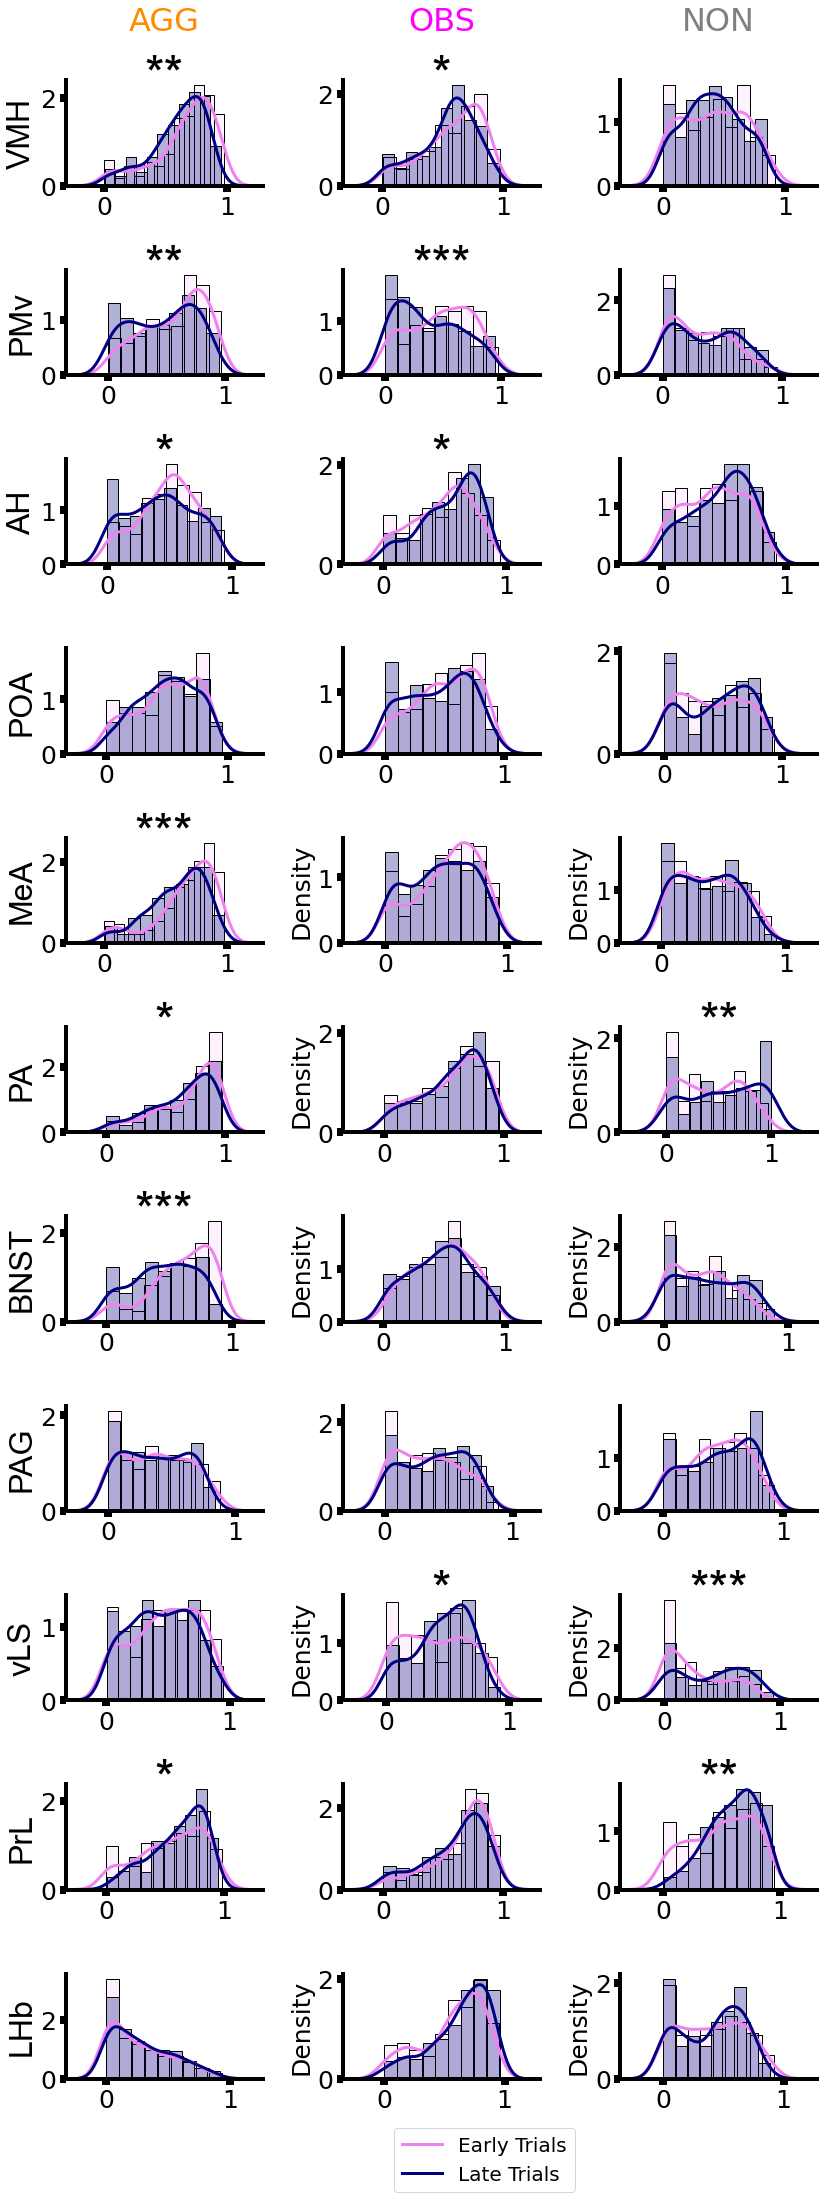

In [48]:
from matplotlib.lines import Line2D
from scipy.stats import ks_2samp
from permute.core import two_sample
new_idx = np.array([12, 16, 8, 4, 10, 20, 6, 14, 2, 0, 18])
norm_idx = (new_idx/2).astype(int)
all_labels = [x.replace(' (E)', '').replace(' (I)', '').replace(' (DA)','') for x in np.array(region_ids)[new_idx]]
p_values = []
ks_stats = []

fig, ax = plt.subplots(11, 3, figsize=(12, 30))
# ax = ax.flatten()

for r,roi in enumerate(norm_idx):

    ### AGG
    agg_early_distbs = []
    agg_late_distbs = []
    for mouse in agg_rsquareds.keys():
        agg_early_distbs.extend(agg_rsquareds[mouse][roi, :30])
        agg_late_distbs.extend(agg_rsquareds[mouse][roi, -30:])
    agg_early_distbs = np.array(agg_early_distbs)
    agg_early_distbs = agg_early_distbs[~np.isnan(agg_early_distbs)]
    agg_late_distbs = np.array(agg_late_distbs)
    agg_late_distbs = agg_late_distbs[~np.isnan(agg_late_distbs)]
    print('%s: EXP early N =  %d, EXP late N = %d' % (all_labels[r], len(agg_early_distbs), len(agg_late_distbs)))
    sns.histplot(agg_early_distbs, ax=ax[r,0], stat='density', color='violet', kde=False, alpha=0.1)
    sns.kdeplot(agg_early_distbs, ax=ax[r, 0], color='violet', lw=3)
    sns.histplot(agg_late_distbs, ax=ax[r,0], stat='density', color='navy', kde=False, alpha=0.3)
    sns.kdeplot(agg_late_distbs, ax=ax[r, 0], color='navy', lw=3)

    ### OBS
    obs_early_distbs = []
    obs_late_distbs = []
    for mouse in obs_rsquareds.keys():
        obs_early_distbs.extend(obs_rsquareds[mouse][roi, :30])
        obs_late_distbs.extend(obs_rsquareds[mouse][roi, -30:])
    obs_early_distbs = np.array(obs_early_distbs)
    obs_early_distbs = obs_early_distbs[~np.isnan(obs_early_distbs)]
    obs_late_distbs = np.array(obs_late_distbs)
    obs_late_distbs = obs_late_distbs[~np.isnan(obs_late_distbs)]
    print('%s: OBS early N = %d, OBS late N = %d' % (all_labels[r], len(obs_early_distbs), len(obs_late_distbs)))
    sns.histplot(obs_early_distbs, ax=ax[r,1], stat='density', color='violet', kde=False, alpha=0.1)
    sns.kdeplot(obs_early_distbs, ax=ax[r, 1], color='violet', lw=3)
    sns.histplot(obs_late_distbs, ax=ax[r,1], stat='density', color='navy', kde=False, alpha=0.3)
    sns.kdeplot(obs_late_distbs, ax=ax[r, 1], color='navy', lw=3)

    ### NON
    non_early_distbs = []
    non_late_distbs = []
    for mouse in non_rsquareds.keys():
        non_early_distbs.extend(non_rsquareds[mouse][roi, :30])
        non_late_distbs.extend(non_rsquareds[mouse][roi, -30:])
    non_early_distbs = np.array(non_early_distbs)
    non_early_distbs = non_early_distbs[~np.isnan(non_early_distbs)]
    non_late_distbs = np.array(non_late_distbs)
    non_late_distbs = non_late_distbs[~np.isnan(non_late_distbs)]
    print('%s: NON early N = %d, NON late N = %d' % (all_labels[r], len(non_early_distbs), len(non_late_distbs)))
    sns.histplot(non_early_distbs, ax=ax[r,2], stat='density', color='violet', kde=False, alpha=0.1)
    sns.kdeplot(non_early_distbs, ax=ax[r, 2], color='violet', lw=3)
    sns.histplot(non_late_distbs, ax=ax[r,2], stat='density', color='navy', kde=False, alpha=0.3)
    sns.kdeplot(non_late_distbs, ax=ax[r, 2], color='navy', lw=3)

    ax[roi, 0].set_ylabel(all_labels[roi], fontfamily='Arial', fontsize=32)
    ax[roi, 1].set_ylabel('')
    ax[roi, 2].set_ylabel('')

    # tests
    ks_statistic1, p_value1 = ks_2samp(agg_early_distbs, agg_late_distbs)
    ks_statistic2, p_value2 = ks_2samp(obs_early_distbs, obs_late_distbs)
    ks_statistic3, p_value3 = ks_2samp(non_early_distbs, non_late_distbs)
    # p_value1, _ = two_sample(agg_early_distbs, agg_late_distbs, reps=1000)
    # p_value2, _ = two_sample(obs_early_distbs, obs_late_distbs, reps=1000)
    # p_value3, _ = two_sample(non_early_distbs, non_late_distbs, reps=1000)
    p_values.extend([p_value1, p_value2, p_value3])
    ks_stats.extend([ks_statistic1, ks_statistic2, ks_statistic3])

    # if tests have already been performed
    try:
        if pvals_corrected_AGG[r] < 0.05:
            if pvals_corrected_AGG[r] < 0.001:
                marker= '***'
            elif pvals_corrected_AGG[r] < 0.01:
                marker= '**'
            else:
                marker= '*'
            ax[r, 0].text(0.5, 0.9, marker, transform=ax[r, 0].transAxes, fontsize=50, color='black', ha='center', fontfamily='Arial')
        if pvals_corrected_OBS[r] < 0.05:
            if pvals_corrected_OBS[r] < 0.001:
                marker= '***'
            elif pvals_corrected_OBS[r] < 0.01:
                marker= '**'
            else:
                marker= '*'
            ax[r, 1].text(0.5, 0.9, marker, transform=ax[r, 1].transAxes, fontsize=50, color='black', ha='center', fontfamily='Arial')
        if pvals_corrected_NON[r] < 0.05:
            if pvals_corrected_NON[r] < 0.001:
                marker= '***'
            elif pvals_corrected_NON[r] < 0.01:
                marker= '**'
            else:
                marker= '*'
            ax[r, 2].text(0.5, 0.9, marker, transform=ax[r, 2].transAxes, fontsize=50, color='black', ha='center', fontfamily='Arial')
    except NameError:
        continue

sns.despine()

ax[0,0].set_title('AGG', fontsize=32, color='darkorange', pad=50)
ax[0,1].set_title('OBS', fontsize=32, color='magenta', pad=50)
ax[0,2].set_title('NON', fontsize=32, color='gray', pad=50)

# legend
legend_handles = [
    Line2D([0], [0], color='violet', lw=3, label='Early Trials'),
    Line2D([0], [0], color='navy', lw=3, label='Late Trials')
]

# Add the legend to the far right of the plot
fig.legend(handles=legend_handles, loc='upper right', fontsize=20, frameon=True, bbox_to_anchor=(0.7, 0.01))
plt.tight_layout()
# plt.savefig('./figures/agg_obs_non_r2_trainingPeriod.svg', dpi=300)	

In [41]:
from statsmodels.stats.multitest import multipletests

rows = []

### AGG
p_values_AGG = np.array(p_values)[0::3]
ks_stats_AGG = np.array(ks_stats)[0::3]
reject, pvals_corrected_AGG, _, _ = multipletests(p_values_AGG, method='fdr_tsbh')
for i in np.arange(11):
    print('AGG %s : KS = %f, p = %f' % (all_labels[i], ks_stats_AGG[i], pvals_corrected_AGG[i]))
    rows.append('p = %f' % pvals_corrected_AGG[i])

### OBS
p_values_OBS = np.array(p_values)[1::3]
ks_stats_OBS = np.array(ks_stats)[1::3]
reject, pvals_corrected_OBS, _, _ = multipletests(p_values_OBS, method='fdr_tsbh')
for i in np.arange(11):
    print('OBS %s : KS = %f, p = %f' % (all_labels[i], ks_stats_OBS[i], pvals_corrected_OBS[i]))
    rows.append('p = %f' % pvals_corrected_OBS[i])

### NON
p_values_NON = np.array(p_values)[2::3]
ks_stats_NON = np.array(ks_stats)[2::3]
reject, pvals_corrected_NON, _, _ = multipletests(p_values_NON, method='fdr_tsbh')
for i in np.arange(11):
    print('NON %s : KS = %f, p = %f' % (all_labels[i], ks_stats_NON[i], pvals_corrected_NON[i]))
    rows.append('p = %f' % pvals_corrected_NON[i])

df = pd.DataFrame(rows, columns=['Results'])
# df.to_excel('stats_list.xlsx', index=False)

AGG VMH : KS = 0.162963, p = 0.003019
AGG PMv : KS = 0.171429, p = 0.006167
AGG AH : KS = 0.125926, p = 0.027550
AGG POA : KS = 0.066667, p = 0.396884
AGG MeA : KS = 0.181481, p = 0.000798
AGG PA : KS = 0.147619, p = 0.024564
AGG BNST : KS = 0.237500, p = 0.000014
AGG PAG : KS = 0.061905, p = 0.445687
AGG vLS : KS = 0.077778, p = 0.282796
AGG PrL : KS = 0.118519, p = 0.038563
AGG LHb : KS = 0.085714, p = 0.282796
OBS VMH : KS = 0.166667, p = 0.010114
OBS PMv : KS = 0.214286, p = 0.000863
OBS AH : KS = 0.176190, p = 0.010114
OBS POA : KS = 0.114286, p = 0.100187
OBS MeA : KS = 0.133333, p = 0.062062
OBS PA : KS = 0.071429, p = 0.461215
OBS BNST : KS = 0.052381, p = 0.595891
OBS PAG : KS = 0.114286, p = 0.100187
OBS vLS : KS = 0.166667, p = 0.010114
OBS PrL : KS = 0.128571, p = 0.062062
OBS LHb : KS = 0.128571, p = 0.062062
NON VMH : KS = 0.100000, p = 0.293164
NON PMv : KS = 0.109559, p = 0.203870
NON AH : KS = 0.138889, p = 0.120974
NON POA : KS = 0.127778, p = 0.120974
NON MeA : KS = 

5. Assess E2E correlations trial by trial

In [15]:
# run OLS on each trial for each region / individual

EI_regions = np.array([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20])

agg_rsquareds = {}
for mouse in list(TW_agg_dict.keys()):
    sample = TW_agg_dict[mouse]
    sample = sample[:, :, :-1]
    r_squared_array = np.zeros((len(EI_regions), sample.shape[0]))
    r_squared_array[:] = np.nan
    for r, region in enumerate(EI_regions):
        E_idxs = np.asarray([int(x) for x in EI_regions if int(region) != x])
        X = sample[:, :, E_idxs]
        X = X[:, :, ~np.all(np.isnan(X), axis=(0, 1))]
        y = sample[:, :, region]
        for trial in np.arange(X.shape[0]):
            X_trial = X[trial, :, :]
            y_trial = y[trial, :]
            y_trial = y_trial[~np.isnan(y_trial)]
            y_trial = y_trial.reshape(-1, 1)
            try:
                model = sm.OLS(y_trial, X_trial).fit()
            except ValueError:
                continue
            r_squared_array[r, trial] = model.rsquared
    agg_rsquareds[mouse] = r_squared_array

obs_rsquareds = {}
for mouse in list(TW_obs_dict.keys()):
    sample = TW_obs_dict[mouse]
    sample = sample[:, :, :-1]
    r_squared_array = np.zeros((len(EI_regions), sample.shape[0]))
    r_squared_array[:] = np.nan
    for r, region in enumerate(EI_regions):
        E_idxs = np.asarray([int(x) for x in EI_regions if int(region) != x])
        X = sample[:, :, E_idxs]
        X = X[:, :, ~np.all(np.isnan(X), axis=(0, 1))]
        y = sample[:, :, region]
        for trial in np.arange(X.shape[0]):
            X_trial = X[trial, :, :]
            y_trial = y[trial, :]
            y_trial = y_trial[~np.isnan(y_trial)]
            y_trial = y_trial.reshape(-1, 1)
            try:
                model = sm.OLS(y_trial, X_trial).fit()
            except ValueError:
                continue
            r_squared_array[r, trial] = model.rsquared
    obs_rsquareds[mouse] = r_squared_array

non_rsquareds = {}
for mouse in list(TW_non_dict.keys()):
    sample = TW_non_dict[mouse]
    sample = sample[:, :, :-1]
    r_squared_array = np.zeros((len(EI_regions), sample.shape[0]))
    r_squared_array[:] = np.nan
    for r, region in enumerate(EI_regions):
        E_idxs = np.asarray([int(x) for x in EI_regions if int(region) != x])
        X = sample[:, :, E_idxs]
        X = X[:, :, ~np.all(np.isnan(X), axis=(0, 1))]
        y = sample[:, :, region]
        for trial in np.arange(X.shape[0]):
            X_trial = X[trial, :, :]
            y_trial = y[trial, :]
            y_trial = y_trial[~np.isnan(y_trial)]
            y_trial = y_trial.reshape(-1, 1)
            try:
                model = sm.OLS(y_trial, X_trial).fit()
            except ValueError:
                continue
            r_squared_array[r, trial] = model.rsquared
    r_squared_array = np.where(r_squared_array < 0, 0, r_squared_array)
    non_rsquareds[mouse] = r_squared_array



c:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


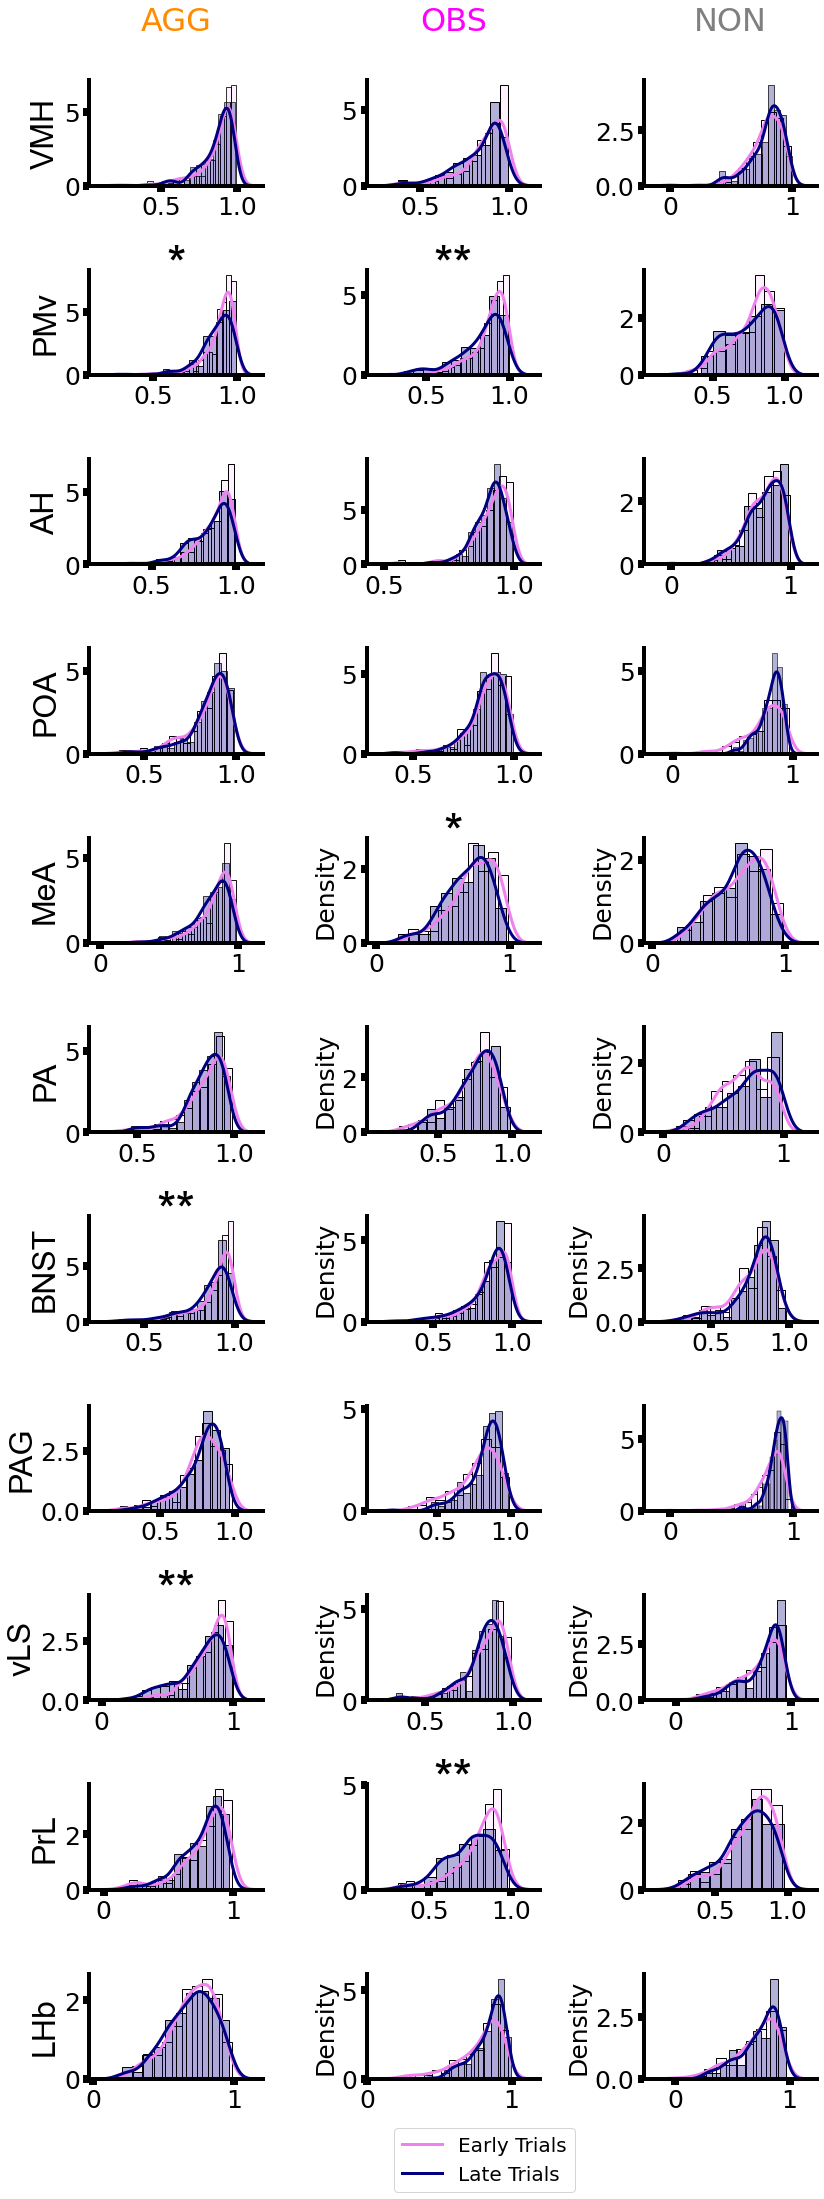

In [71]:
from matplotlib.lines import Line2D
from scipy.stats import ks_2samp
new_idx = np.array([12, 16, 8, 4, 10, 20, 6, 14, 2, 0, 18])
norm_idx = (new_idx/2).astype(int)
all_labels = [x.replace(' (E)', '').replace(' (I)', '').replace(' (DA)','') for x in np.array(region_ids)[new_idx]]
# p_values_exc = []

fig, ax = plt.subplots(11, 3, figsize=(12, 30))
# ax = ax.flatten()

for r,roi in enumerate(norm_idx):

    ### AGG
    agg_early_distbs = []
    agg_late_distbs = []
    for mouse in agg_rsquareds.keys():
        agg_early_distbs.extend(agg_rsquareds[mouse][roi, :30])
        agg_late_distbs.extend(agg_rsquareds[mouse][roi, -30:])
    agg_early_distbs = np.array(agg_early_distbs)
    agg_early_distbs = agg_early_distbs[~np.isnan(agg_early_distbs)]
    agg_late_distbs = np.array(agg_late_distbs)
    agg_late_distbs = agg_late_distbs[~np.isnan(agg_late_distbs)]
    sns.histplot(agg_early_distbs, ax=ax[r,0], stat='density', color='violet', kde=False, alpha=0.1)
    sns.kdeplot(agg_early_distbs, ax=ax[r, 0], color='violet', lw=3)
    sns.histplot(agg_late_distbs, ax=ax[r,0], stat='density', color='navy', kde=False, alpha=0.3)
    sns.kdeplot(agg_late_distbs, ax=ax[r, 0], color='navy', lw=3)

    ### OBS
    obs_early_distbs = []
    obs_late_distbs = []
    for mouse in obs_rsquareds.keys():
        obs_early_distbs.extend(obs_rsquareds[mouse][roi, :30])
        obs_late_distbs.extend(obs_rsquareds[mouse][roi, -30:])
    obs_early_distbs = np.array(obs_early_distbs)
    obs_early_distbs = obs_early_distbs[~np.isnan(obs_early_distbs)]
    obs_late_distbs = np.array(obs_late_distbs)
    obs_late_distbs = obs_late_distbs[~np.isnan(obs_late_distbs)]
    sns.histplot(obs_early_distbs, ax=ax[r,1], stat='density', color='violet', kde=False, alpha=0.1)
    sns.kdeplot(obs_early_distbs, ax=ax[r, 1], color='violet', lw=3)
    sns.histplot(obs_late_distbs, ax=ax[r,1], stat='density', color='navy', kde=False, alpha=0.3)
    sns.kdeplot(obs_late_distbs, ax=ax[r, 1], color='navy', lw=3)

    ### NON
    non_early_distbs = []
    non_late_distbs = []
    for mouse in non_rsquareds.keys():
        non_early_distbs.extend(non_rsquareds[mouse][roi, :30])
        non_late_distbs.extend(non_rsquareds[mouse][roi, -30:])
    non_early_distbs = np.array(non_early_distbs)
    non_early_distbs = non_early_distbs[~np.isnan(non_early_distbs)]
    non_late_distbs = np.array(non_late_distbs)
    non_late_distbs = non_late_distbs[~np.isnan(non_late_distbs)]
    sns.histplot(non_early_distbs, ax=ax[r,2], stat='density', color='violet', kde=False, alpha=0.1)
    sns.kdeplot(non_early_distbs, ax=ax[r, 2], color='violet', lw=3)
    sns.histplot(non_late_distbs, ax=ax[r,2], stat='density', color='navy', kde=False, alpha=0.3)
    sns.kdeplot(non_late_distbs, ax=ax[r, 2], color='navy', lw=3)

    ax[roi, 0].set_ylabel(all_labels[roi], fontfamily='Arial', fontsize=32)
    ax[roi, 1].set_ylabel('')
    ax[roi, 2].set_ylabel('')

    # tests
    # ks_statistic, p_value1 = ks_2samp(agg_early_distbs, agg_late_distbs)
    # ks_statistic, p_value2 = ks_2samp(obs_early_distbs, obs_late_distbs)
    # ks_statistic, p_value3 = ks_2samp(non_early_distbs, non_late_distbs)
    # p_value1, _ = two_sample(agg_early_distbs, agg_late_distbs, reps=2000)
    # p_value2, _ = two_sample(obs_early_distbs, obs_late_distbs, reps=2000)
    # p_value3, _ = two_sample(non_early_distbs, non_late_distbs, reps=2000)
    # p_values_exc.extend([p_value1, p_value2, p_value3])

    # if tests have already been performed
    try:
        if pvals_corrected_AGG[r] < 0.05:
            if pvals_corrected_AGG[r] < 0.001:
                marker= '***'
            elif pvals_corrected_AGG[r] < 0.01:
                marker= '**'
            else:
                marker= '*'
            ax[r, 0].text(0.5, 0.9, marker, transform=ax[r, 0].transAxes, fontsize=50, color='black', ha='center', fontfamily='Arial')
        if pvals_corrected_OBS[r] < 0.05:
            if pvals_corrected_OBS[r] < 0.001:
                marker= '***'
            elif pvals_corrected_OBS[r] < 0.01:
                marker= '**'
            else:
                marker= '*'
            ax[r, 1].text(0.5, 0.9, marker, transform=ax[r, 1].transAxes, fontsize=50, color='black', ha='center', fontfamily='Arial')
        if pvals_corrected_NON[r] < 0.05:
            if pvals_corrected_NON[r] < 0.001:
                marker= '***'
            elif pvals_corrected_NON[r] < 0.01:
                marker= '**'
            else:
                marker= '*'
            ax[r, 2].text(0.5, 0.9, marker, transform=ax[r, 2].transAxes, fontsize=50, color='black', ha='center', fontfamily='Arial')
    except NameError:
        continue

sns.despine()

ax[0,0].set_title('AGG', fontsize=32, color='darkorange', pad=50)
ax[0,1].set_title('OBS', fontsize=32, color='magenta', pad=50)
ax[0,2].set_title('NON', fontsize=32, color='gray', pad=50)

# legend
legend_handles = [
    Line2D([0], [0], color='violet', lw=3, label='Early Trials'),
    Line2D([0], [0], color='navy', lw=3, label='Late Trials')
]

# Add the legend to the far right of the plot
fig.legend(handles=legend_handles, loc='upper right', fontsize=20, frameon=True, bbox_to_anchor=(0.7, 0.01))
plt.tight_layout()
# plt.savefig('./figures/agg_obs_non_r2_trainingPeriod.svg', dpi=300)	

In [70]:
# RE-RUN ABOVE CELL AFTER RUNNING THIS CELL TO PLOT ACCURATE SIGNIFICANCE STARS

from statsmodels.stats.multitest import multipletests
### AGG
p_values_AGG = np.array(p_values_exc)[0::3]
reject, pvals_corrected_AGG, _, _ = multipletests(p_values_AGG, method='hommel')
for i in np.arange(11):
    print('AGG %s : %f' % (all_labels[i], pvals_corrected_AGG[i]))

### OBS
p_values_OBS = np.array(p_values_exc)[1::3]
reject, pvals_corrected_OBS, _, _ = multipletests(p_values_OBS, method='hommel')
for i in np.arange(11):
    print('OBS %s : %f' % (all_labels[i], pvals_corrected_OBS[i]))

### NON
p_values_NON = np.array(p_values_exc)[2::3]
reject, pvals_corrected_NON, _, _ = multipletests(p_values_NON, method='hommel')
for i in np.arange(11):
    print('NON %s : %f' % (all_labels[i], pvals_corrected_NON[i]))

AGG VMH : 0.833083
AGG PMv : 0.017991
AGG AH : 0.091954
AGG POA : 0.833083
AGG MeA : 0.167916
AGG PA : 0.718141
AGG BNST : 0.004998
AGG PAG : 0.833083
AGG vLS : 0.004998
AGG PrL : 0.335832
AGG LHb : 0.722639
OBS VMH : 0.071964
OBS PMv : 0.004998
OBS AH : 0.346327
OBS POA : 1.000000
OBS MeA : 0.013493
OBS PA : 1.000000
OBS BNST : 0.338831
OBS PAG : 1.000000
OBS vLS : 0.577211
OBS PrL : 0.004998
OBS LHb : 1.000000
NON VMH : 1.000000
NON PMv : 0.589205
NON AH : 1.000000
NON POA : 1.000000
NON MeA : 0.643178
NON PA : 1.000000
NON BNST : 1.000000
NON PAG : 1.000000
NON vLS : 1.000000
NON PrL : 0.214393
NON LHb : 1.000000


5. Multi-region model and weight assessment

In [50]:
# run OLS on each trial for each region / individual

from statsmodels.tools.sm_exceptions import PerfectSeparationError
np.random.seed(1239419)
warnings.filterwarnings("ignore", category=RuntimeWarning)
from tqdm import tqdm

constrained_idxs = np.array([16, 14, 10, 13, 17, 11]) # orig
constrained_idxs = np.array([16, 8, 4, 14, 10, 20, 13, 17, 9, 5, 11, 21]) # <----
roi2pred = 12
n_perms = 30

### RUN AGG

agg_rsquareds = {}
agg_weights = {}
agg_kos = {}

pbar = tqdm(enumerate(TW_agg_dict.keys()), total=len(TW_agg_dict.keys())) # progress bar
for a, mouse in pbar:
    sample = TW_agg_dict[mouse]
    r_squared_array = np.zeros((sample.shape[0]))
    r_squared_array[:] = np.nan
    weights_array = np.zeros((len(constrained_idxs), sample.shape[0]))
    weights_array[:] = np.nan
    kos_array = np.zeros((len(constrained_idxs), sample.shape[0]))
    kos_array[:] = np.nan

    # format X and y
    y = sample[:, :, roi2pred]
    y = y[:, :, ~np.all(np.isnan(y), axis=(0, 1))]

    # format X
    X = sample[:, :, constrained_idxs]
    X = X[:, :, ~np.all(np.isnan(X), axis=(0, 1))] # clean rois with no data
    X = X[~np.any(np.isnan(X), axis=(1, 2)), :, :] # clean trials with no data
    if X.shape[-1] < len(constrained_idxs):
        print('Skipping AGG %s' % mouse)
        continue

    # run glm for each trial
    for trial in np.arange(X.shape[0]):

        # fit model
        X_trial = X[trial]
        y_trial = y[trial]
        try:
            model = sm.GLM(y_trial, X_trial).fit()
        except ValueError:
            continue
        best_score = r2_score(y_trial, model.predict(X_trial))
        if best_score<0:
            best_score=0

        # perform region knockouts
        knockouts = np.zeros((X.shape[-1]))
        for knockout_idx in np.arange(X.shape[-1]):
            avg_ko = []
            for n in np.arange(n_perms):
                X_shuffled = X_trial.copy()
                np.random.shuffle(X_shuffled[:, knockout_idx])
                y_pred = model.predict(X_shuffled)
                ko_score = r2_score(y_trial, y_pred)
                if ko_score < 0:
                    ko_score = 0
                avg_ko.append(ko_score)
            ko_score = np.mean(avg_ko) 
            knockout_score_difference = best_score - ko_score
            if knockout_score_difference < 0:
                knockout_score_difference = 0
            knockouts[knockout_idx] = knockout_score_difference

        # store results 
        r_squared_array[trial] = best_score
        weights_array[:, trial] = model.params.flatten()
        kos_array[:, trial] = knockouts

    agg_rsquareds[mouse] = r_squared_array
    agg_weights[mouse] = weights_array
    agg_kos[mouse] = kos_array

# ### RUN OBS

obs_rsquareds = {}
obs_weights = {}
obs_kos = {}

pbar = tqdm(enumerate(TW_obs_dict.keys()), total=len(TW_obs_dict.keys())) # progress bar
for a, mouse in pbar:
    sample = TW_obs_dict[mouse]
    r_squared_array = np.zeros((sample.shape[0]))
    r_squared_array[:] = np.nan
    weights_array = np.zeros((len(constrained_idxs), sample.shape[0]))
    weights_array[:] = np.nan
    kos_array = np.zeros((len(constrained_idxs), sample.shape[0]))
    kos_array[:] = np.nan

    # format X and y
    y = sample[:, :, roi2pred]
    y = y[:, :, ~np.all(np.isnan(y), axis=(0, 1))]

    # format X
    X = sample[:, :, constrained_idxs]
    X = X[:, :, ~np.all(np.isnan(X), axis=(0, 1))] # clean rois with no data
    X = X[~np.any(np.isnan(X), axis=(1, 2)), :, :] # clean trials with no data
    if X.shape[-1] < len(constrained_idxs):
        print('Skipping OBS %s' % mouse)
        continue

    # run glm for each trial
    for trial in np.arange(X.shape[0]):

        # fit model
        X_trial = X[trial]
        y_trial = y[trial]
        try:
            model = sm.GLM(y_trial, X_trial).fit()
        except ValueError:
            continue
        best_score = r2_score(y_trial, model.predict(X_trial))
        if best_score<0:
            best_score=0

        # perform region knockouts
        knockouts = np.zeros((X.shape[-1]))
        for knockout_idx in np.arange(X.shape[-1]):
            avg_ko = []
            for n in np.arange(n_perms):
                X_shuffled = X_trial.copy()
                np.random.shuffle(X_shuffled[:, knockout_idx])
                y_pred = model.predict(X_shuffled)
                ko_score = r2_score(y_trial, y_pred)
                if ko_score < 0:
                    ko_score = 0
                avg_ko.append(ko_score)
            ko_score = np.mean(avg_ko) 
            knockout_score_difference = best_score - ko_score
            if knockout_score_difference < 0:
                knockout_score_difference = 0
            knockouts[knockout_idx] = knockout_score_difference

        # store results 
        r_squared_array[trial] = best_score
        weights_array[:, trial] = model.params.flatten()
        kos_array[:, trial] = knockouts
    
    obs_rsquareds[mouse] = r_squared_array
    obs_weights[mouse] = weights_array
    obs_kos[mouse] = kos_array

### RUN NON

non_rsquareds = {}
non_weights = {}
non_kos = {}

pbar = tqdm(enumerate(TW_non_dict.keys()), total=len(TW_non_dict.keys())) # progress bar
for a, mouse in pbar:
    sample = TW_non_dict[mouse]
    r_squared_array = np.zeros((sample.shape[0]))
    r_squared_array[:] = np.nan
    weights_array = np.zeros((len(constrained_idxs), sample.shape[0]))
    weights_array[:] = np.nan
    kos_array = np.zeros((len(constrained_idxs), sample.shape[0]))
    kos_array[:] = np.nan

    # format X and y
    y = sample[:, :, roi2pred]
    y = y[:, :, ~np.all(np.isnan(y), axis=(0, 1))]

    # format X
    X = sample[:, :, constrained_idxs]
    X = X[:, :, ~np.all(np.isnan(X), axis=(0, 1))] # clean rois with no data
    X = X[~np.any(np.isnan(X), axis=(1, 2)), :, :] # clean trials with no data
    if X.shape[-1] < len(constrained_idxs):
        print('Skipping NON %s' % mouse)
        continue

    # run glm for each trial
    for trial in np.arange(X.shape[0]):

        # fit model
        X_trial = X[trial]
        y_trial = y[trial]
        try:
            try:
                model = sm.GLM(y_trial, X_trial).fit()
            except ValueError:
                continue
        except PerfectSeparationError:
            print('Perfect Separation Error in NON %s, trial %s' % (mouse, trial))
            print('Skipping trial...')
            continue


        best_score = r2_score(y_trial, model.predict(X_trial))
        if best_score<0:
            best_score=0

        # perform region knockouts
        knockouts = np.zeros((X.shape[-1]))
        for knockout_idx in np.arange(X.shape[-1]):
            avg_ko = []
            for n in np.arange(n_perms):
                X_shuffled = X_trial.copy()
                np.random.shuffle(X_shuffled[:, knockout_idx])
                y_pred = model.predict(X_shuffled)
                ko_score = r2_score(y_trial, y_pred)
                if ko_score < 0:
                    ko_score = 0
                avg_ko.append(ko_score)
            ko_score = np.mean(avg_ko) 
            knockout_score_difference = best_score - ko_score
            if knockout_score_difference < 0:
                knockout_score_difference = 0
            knockouts[knockout_idx] = knockout_score_difference

        # store results 
        r_squared_array[trial] = best_score
        weights_array[:, trial] = model.params.flatten()
        kos_array[:, trial] = knockouts

    non_rsquareds[mouse] = r_squared_array
    non_weights[mouse] = weights_array
    non_kos[mouse] = kos_array

100%|██████████| 9/9 [00:47<00:00,  5.22s/it]


Skipping AGG mouse7
Skipping AGG mouse8


 67%|██████▋   | 4/6 [00:25<00:12,  6.29s/it]

Perfect Separation Error in NON mouse4, trial 165
Skipping trial...
Perfect Separation Error in NON mouse4, trial 187
Skipping trial...


 83%|████████▎ | 5/6 [00:35<00:07,  7.77s/it]

Perfect Separation Error in NON mouse5, trial 129
Skipping trial...


100%|██████████| 6/6 [00:46<00:00,  7.67s/it]


PMv: AGG early N = 210, AGG late N = 210
PMv: OBS early N = 210, OBS late N = 210
PMv: NON early N = 179, NON late N = 180
AH: AGG early N = 210, AGG late N = 210
AH: OBS early N = 210, OBS late N = 210
AH: NON early N = 179, NON late N = 180
POA: AGG early N = 210, AGG late N = 210
POA: OBS early N = 210, OBS late N = 210
POA: NON early N = 179, NON late N = 180
PAG: AGG early N = 210, AGG late N = 210
PAG: OBS early N = 210, OBS late N = 210
PAG: NON early N = 179, NON late N = 180
MeA: AGG early N = 210, AGG late N = 210
MeA: OBS early N = 210, OBS late N = 210
MeA: NON early N = 179, NON late N = 180
PA: AGG early N = 210, AGG late N = 210
PA: OBS early N = 210, OBS late N = 210
PA: NON early N = 179, NON late N = 180
VMH: AGG early N = 210, AGG late N = 210
VMH: OBS early N = 210, OBS late N = 210
VMH: NON early N = 179, NON late N = 180
PMv: AGG early N = 210, AGG late N = 210
PMv: OBS early N = 210, OBS late N = 210
PMv: NON early N = 179, NON late N = 180
AH: AGG early N = 210,

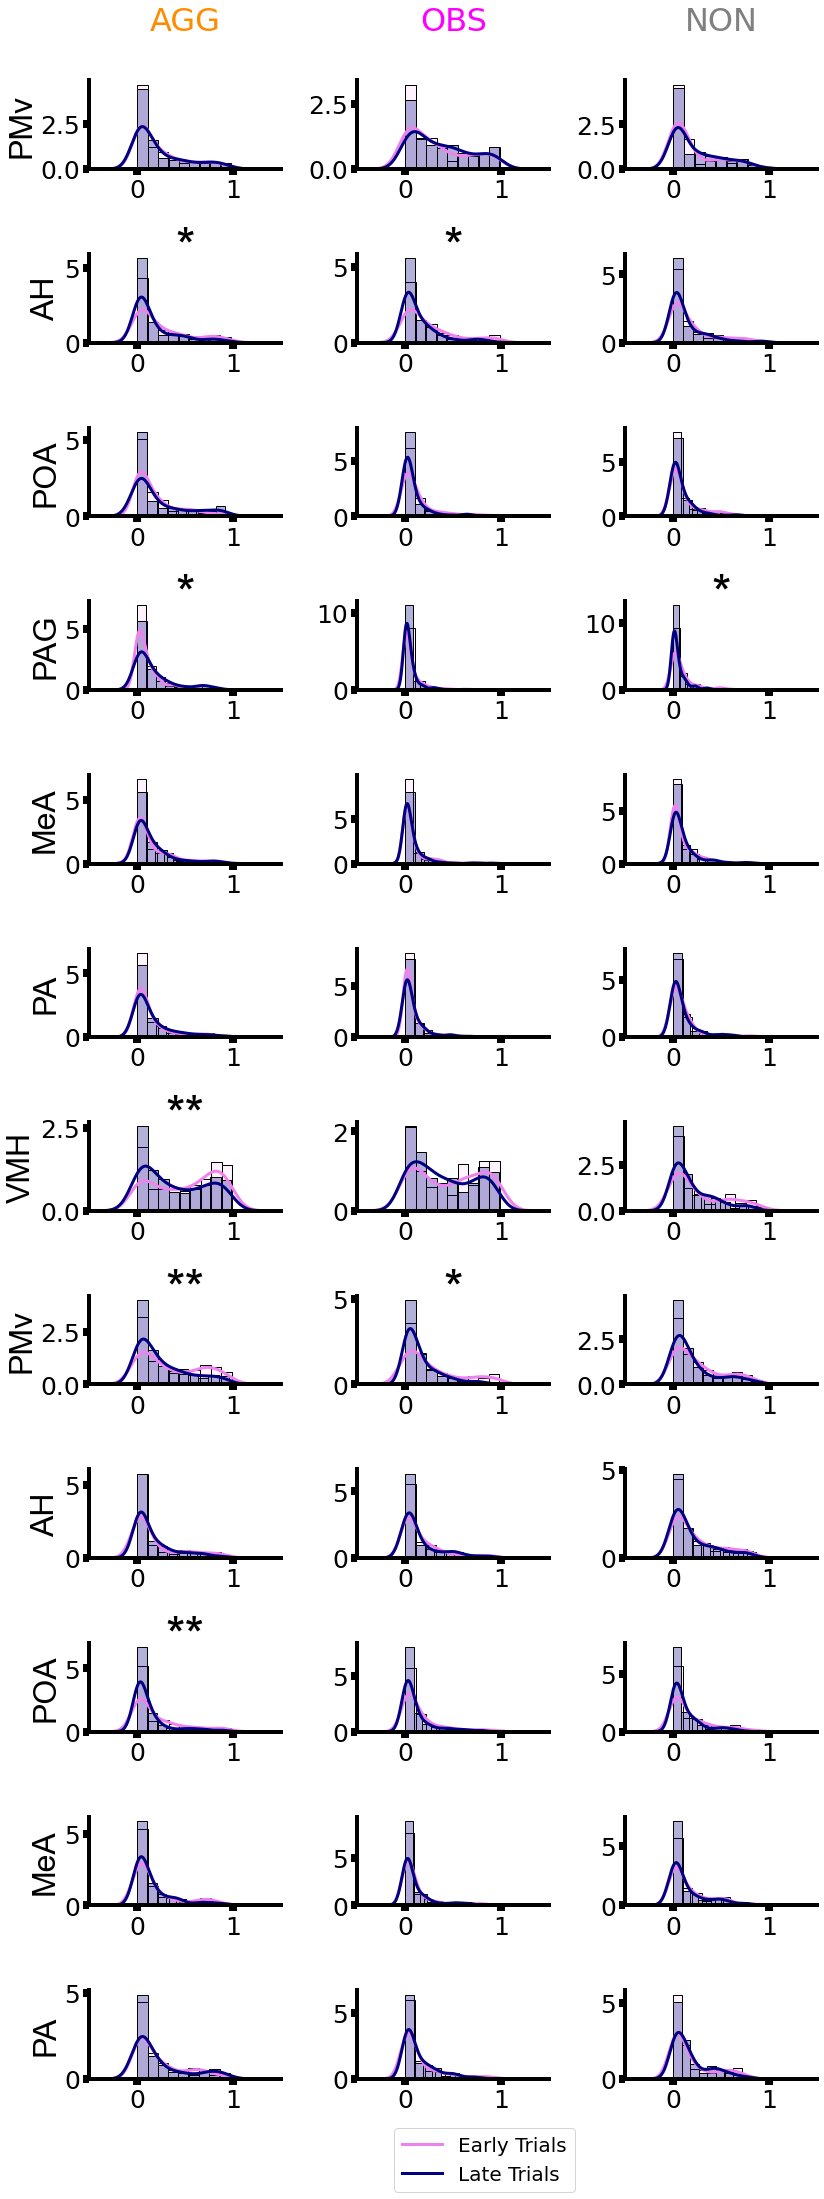

In [53]:
from matplotlib.lines import Line2D
from scipy.stats import ks_2samp
new_idx = np.arange(len(constrained_idxs))
norm_idx = new_idx.copy()
all_labels = [x.replace(' (E)', '').replace(' (I)', '').replace(' (DA)','') for x in np.array(region_ids)[constrained_idxs]]
p_values_multi = []
fig, ax = plt.subplots(len(constrained_idxs), 3, figsize=(12, (len(constrained_idxs)*2.5)))
ntrials = 30
nbins=9

for r, roi in enumerate(norm_idx):

    ### AGG
    agg_early_distbs = []
    agg_late_distbs = []
    for mouse in agg_rsquareds.keys():
        agg_early_distbs.extend(agg_kos[mouse][roi, :ntrials])
        agg_late_distbs.extend(agg_kos[mouse][roi, -ntrials:])
    agg_early_distbs = np.array(agg_early_distbs)
    agg_early_distbs = agg_early_distbs[~np.isnan(agg_early_distbs)]
    agg_late_distbs = np.array(agg_late_distbs)
    agg_late_distbs = agg_late_distbs[~np.isnan(agg_late_distbs)]
    print('%s: AGG early N = %d, AGG late N = %d' % (all_labels[r], len(agg_early_distbs), len(agg_late_distbs)))
    sns.histplot(agg_early_distbs, ax=ax[r,0], stat='density', color='violet', kde=False, alpha=0.1, bins=nbins)
    sns.kdeplot(agg_early_distbs, ax=ax[r, 0], color='violet', lw=3)
    sns.histplot(agg_late_distbs, ax=ax[r,0], stat='density', color='navy', kde=False, alpha=0.3, bins=nbins)
    sns.kdeplot(agg_late_distbs, ax=ax[r, 0], color='navy', lw=3)

    ### OBS
    obs_early_distbs = []
    obs_late_distbs = []
    for mouse in obs_rsquareds.keys():
        obs_early_distbs.extend(obs_kos[mouse][roi, :ntrials])
        obs_late_distbs.extend(obs_kos[mouse][roi, -ntrials:])
    obs_early_distbs = np.array(obs_early_distbs)
    obs_early_distbs = obs_early_distbs[~np.isnan(obs_early_distbs)]
    obs_late_distbs = np.array(obs_late_distbs)
    obs_late_distbs = obs_late_distbs[~np.isnan(obs_late_distbs)]
    print('%s: OBS early N = %d, OBS late N = %d' % (all_labels[r], len(obs_early_distbs), len(obs_late_distbs)))
    sns.histplot(obs_early_distbs, ax=ax[r,1], stat='density', color='violet', kde=False, alpha=0.1, bins=nbins)
    sns.kdeplot(obs_early_distbs, ax=ax[r, 1], color='violet', lw=3)
    sns.histplot(obs_late_distbs, ax=ax[r,1], stat='density', color='navy', kde=False, alpha=0.3, bins=nbins)
    sns.kdeplot(obs_late_distbs, ax=ax[r, 1], color='navy', lw=3)

    ### NON
    non_early_distbs = []
    non_late_distbs = []
    for mouse in non_rsquareds.keys():
        non_early_distbs.extend(non_kos[mouse][roi, :ntrials])
        non_late_distbs.extend(non_kos[mouse][roi, -ntrials:])
    non_early_distbs = np.array(non_early_distbs)
    non_early_distbs = non_early_distbs[~np.isnan(non_early_distbs)]
    non_late_distbs = np.array(non_late_distbs)
    non_late_distbs = non_late_distbs[~np.isnan(non_late_distbs)]
    print('%s: NON early N = %d, NON late N = %d' % (all_labels[r], len(non_early_distbs), len(non_late_distbs)))
    sns.histplot(non_early_distbs, ax=ax[r,2], stat='density', color='violet', kde=False, alpha=0.1, bins=nbins)
    sns.kdeplot(non_early_distbs, ax=ax[r, 2], color='violet', lw=3)
    sns.histplot(non_late_distbs, ax=ax[r,2], stat='density', color='navy', kde=False, alpha=0.3, bins=nbins)
    sns.kdeplot(non_late_distbs, ax=ax[r, 2], color='navy', lw=3)

    ax[roi, 0].set_ylabel(all_labels[roi], fontfamily='Arial', fontsize=32)
    ax[roi, 1].set_ylabel('')
    ax[roi, 2].set_ylabel('')

    # tests
    ks_statistic1, p_value1 = ks_2samp(agg_early_distbs, agg_late_distbs)
    ks_statistic2, p_value2 = ks_2samp(obs_early_distbs, obs_late_distbs)
    ks_statistic3, p_value3 = ks_2samp(non_early_distbs, non_late_distbs)
    p_values_multi.extend([p_value1, p_value2, p_value3])
    ks_stats.extend([ks_statistic1, ks_statistic2, ks_statistic3])

    # if tests have already been performed
    try:
        try:
            if pvals_corrected_AGG[r] < 0.05:
                if pvals_corrected_AGG[r] < 0.001:
                    marker= '***'
                elif pvals_corrected_AGG[r] < 0.01:
                    marker= '**'
                else:
                    marker= '*'
                ax[r, 0].text(0.5, 0.9, marker, transform=ax[r, 0].transAxes, fontsize=50, color='black', ha='center', fontfamily='Arial')
            if pvals_corrected_OBS[r] < 0.05:
                if pvals_corrected_OBS[r] < 0.001:
                    marker= '***'
                elif pvals_corrected_OBS[r] < 0.01:
                    marker= '**'
                else:
                    marker= '*'
                ax[r, 1].text(0.5, 0.9, marker, transform=ax[r, 1].transAxes, fontsize=50, color='black', ha='center', fontfamily='Arial')
            if pvals_corrected_NON[r] < 0.05:
                if pvals_corrected_NON[r] < 0.001:
                    marker= '***'
                elif pvals_corrected_NON[r] < 0.01:
                    marker= '**'
                else:
                    marker= '*'
                ax[r, 2].text(0.5, 0.9, marker, transform=ax[r, 2].transAxes, fontsize=50, color='black', ha='center', fontfamily='Arial')
        except IndexError:
            pass
    except NameError:
        pass
    ax[r, 0].set_xlim(-0.5, 1.5)
    ax[r, 1].set_xlim(-0.5, 1.5)
    ax[r, 2].set_xlim(-0.5, 1.5)

sns.despine()

ax[0,0].set_title('AGG', fontsize=32, color='darkorange', pad=50)
ax[0,1].set_title('OBS', fontsize=32, color='magenta', pad=50)
ax[0,2].set_title('NON', fontsize=32, color='gray', pad=50)

# legend
legend_handles = [
    Line2D([0], [0], color='violet', lw=3, label='Early Trials'),
    Line2D([0], [0], color='navy', lw=3, label='Late Trials')
]

# Add the legend to the far right of the plot
fig.legend(handles=legend_handles, loc='upper right', fontsize=20, frameon=True, bbox_to_anchor=(0.7, 0.01))
plt.tight_layout()
# plt.savefig('./figures/agg_obs_non_kos_trainingPeriod.svg', dpi=300)	

In [52]:
# RE-RUN ABOVE CELL AFTER RUNNING THIS CELL TO PLOT ACCURATE SIGNIFICANCE STARS

from statsmodels.stats.multitest import multipletests
rows = []

### AGG
p_values_AGG = np.array(p_values_multi)[0::3]
ks_stats_AGG = np.array(ks_stats)[0::3]
reject, pvals_corrected_AGG, _, _ = multipletests(p_values_AGG, method='fdr_tsbh')
for i in np.arange(len(constrained_idxs)):
    print('AGG %s : %f' % (all_labels[i], pvals_corrected_AGG[i]))
    # rows.append('KS = %f, p = %f' % (ks_stats_AGG[i], p_values_AGG[i]))
    rows.append('p = %f' % pvals_corrected_AGG[i])

### OBS
p_values_OBS = np.array(p_values_multi)[1::3]
ks_stats_OBS = np.array(ks_stats)[1::3]
reject, pvals_corrected_OBS, _, _ = multipletests(p_values_OBS, method='fdr_tsbh')
for i in np.arange(len(constrained_idxs)):
    print('OBS %s : %f' % (all_labels[i], pvals_corrected_OBS[i]))
    # rows.append('KS = %f, p = %f' % (ks_stats_OBS[i], p_values_OBS[i]))
    rows.append('p = %f' % pvals_corrected_OBS[i])

### NON
p_values_NON = np.array(p_values_multi)[2::3]
ks_stats_NON = np.array(ks_stats)[2::3]
reject, pvals_corrected_NON, _, _ = multipletests(p_values_NON, method='fdr_tsbh')
for i in np.arange(len(constrained_idxs)):
    print('NON %s : %f' % (all_labels[i], pvals_corrected_NON[i]))
    # rows.append('KS = %f, p = %f' % (ks_stats_NON[i], p_values_NON[i]))
    rows.append('p = %f' % pvals_corrected_NON[i])

df = pd.DataFrame(rows, columns=['Results'])
# df.to_excel('stats_list.xlsx', index=False)

AGG PMv : 0.566842
AGG AH : 0.021197
AGG POA : 0.403854
AGG PAG : 0.021197
AGG MeA : 0.346798
AGG PA : 0.403854
AGG VMH : 0.006758
AGG PMv : 0.006758
AGG AH : 0.403854
AGG POA : 0.006758
AGG MeA : 0.403854
AGG PA : 0.471162
OBS PMv : 0.349782
OBS AH : 0.028898
OBS POA : 0.072680
OBS PAG : 0.371570
OBS MeA : 0.780333
OBS PA : 0.742812
OBS VMH : 0.072680
OBS PMv : 0.028898
OBS AH : 0.641038
OBS POA : 0.072680
OBS MeA : 0.740398
OBS PA : 0.332717
NON PMv : 0.298877
NON AH : 0.339877
NON POA : 0.339877
NON PAG : 0.035128
NON MeA : 0.298877
NON PA : 0.597590
NON VMH : 0.108062
NON PMv : 0.108062
NON AH : 0.339877
NON POA : 0.298877
NON MeA : 0.540250
NON PA : 0.457423


### Hard fight

In [4]:
from matplotlib.lines import Line2D
from scipy.stats import ks_2samp
from statsmodels.stats.multitest import multipletests

1. Load data

In [5]:
HF_agg_dict = pd.read_pickle('time-warped_agg_data_HF.pickle')
HF_obs_dict = pd.read_pickle('time-warped_obs_data_HF.pickle')
HF_non_dict = pd.read_pickle('time-warped_non_data_HF.pickle')

2. Map I2E correlation distributions

In [111]:
# run OLS on each trial for each region / individual

period = [0, 400] # this 0 400
EI_regions = np.array([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20])

agg_rsquareds_HF = {}
for mouse in HF_agg_dict.keys():
    sample = HF_agg_dict[mouse]
    r_squared_array = np.zeros((len(EI_regions), sample.shape[0]))
    r_squared_array[:] = np.nan
    for r, region in enumerate(EI_regions):
        X = sample[:, :, region+1]
        y = sample[:, :, region]
        for trial in np.arange(X.shape[0]):
            X_trial = X[trial, :]
            y_trial = y[trial, :]
            X_trial = X_trial[~np.isnan(X_trial)]
            y_trial = y_trial[~np.isnan(y_trial)]
            X_trial = X_trial.reshape(-1, 1)[period[0]:period[1]]
            y_trial = y_trial.reshape(-1, 1)[period[0]:period[1]]
            try:
                model = sm.OLS(y_trial, X_trial).fit()
            except ValueError:
                continue
            r_squared_array[r, trial] = model.rsquared
    agg_rsquareds_HF[mouse] = r_squared_array

obs_rsquareds_HF = {}
for mouse in HF_obs_dict.keys():
    sample = HF_obs_dict[mouse]
    r_squared_array = np.zeros((len(EI_regions), sample.shape[0]))
    r_squared_array[:] = np.nan
    for r, region in enumerate(EI_regions):
        X = sample[:, :, region+1]
        y = sample[:, :, region]
        for trial in np.arange(X.shape[0]):
            X_trial = X[trial, :]
            y_trial = y[trial, :]
            X_trial = X_trial[~np.isnan(X_trial)]
            y_trial = y_trial[~np.isnan(y_trial)]
            X_trial = X_trial.reshape(-1, 1)[period[0]:period[1]]
            y_trial = y_trial.reshape(-1, 1)[period[0]:period[1]]
            model = sm.OLS(y_trial, X_trial).fit()
            r_squared_array[r, trial] = model.rsquared
    obs_rsquareds_HF[mouse] = r_squared_array

non_rsquareds_HF = {}
for mouse in HF_non_dict.keys():
    sample = HF_non_dict[mouse]
    r_squared_array = np.zeros((len(EI_regions), sample.shape[0]))
    r_squared_array[:] = np.nan
    for r, region in enumerate(EI_regions):
        X = sample[:, :, region+1]
        y = sample[:, :, region]
        for trial in np.arange(X.shape[0]):
            X_trial = X[trial, :]
            y_trial = y[trial, :]
            X_trial = X_trial[~np.isnan(X_trial)]
            y_trial = y_trial[~np.isnan(y_trial)]
            X_trial = X_trial.reshape(-1, 1)[period[0]:period[1]]
            y_trial = y_trial.reshape(-1, 1)[period[0]:period[1]]
            model = sm.OLS(y_trial, X_trial).fit()
            r_squared_array[r, trial] = model.rsquared
    non_rsquareds_HF[mouse] = r_squared_array



VMH
AGG = 26, OBS = 21, NON = 17
AGG vs NON; p = 0.738195
OBS vs AGG; p = 0.738195
OBS vs NON; p = 0.738195
###
PMv
AGG = 20, OBS = 21, NON = 17
AGG vs NON; p = 0.003123
OBS vs AGG; p = 0.067298
OBS vs NON; p = 0.015822
###
AH
AGG = 26, OBS = 21, NON = 17
AGG vs NON; p = 0.000466
OBS vs AGG; p = 0.005641
OBS vs NON; p = 0.067053
###
POA
AGG = 22, OBS = 21, NON = 17
AGG vs NON; p = 0.383968
OBS vs AGG; p = 0.274262
OBS vs NON; p = 0.532222
###
MeA
AGG = 26, OBS = 21, NON = 17
AGG vs NON; p = 0.180550
OBS vs AGG; p = 0.294176
OBS vs NON; p = 0.321330
###
PA
AGG = 20, OBS = 21, NON = 17
AGG vs NON; p = 0.034040
OBS vs AGG; p = 0.031810
OBS vs NON; p = 0.320478
###
BNST
AGG = 24, OBS = 21, NON = 17
AGG vs NON; p = 0.002682
OBS vs AGG; p = 0.005798
OBS vs NON; p = 0.267932
###
PAG
AGG = 20, OBS = 21, NON = 17
AGG vs NON; p = 0.580184
OBS vs AGG; p = 0.305885
OBS vs NON; p = 0.702728
###
vLS
AGG = 26, OBS = 21, NON = 17
AGG vs NON; p = 0.315225
OBS vs AGG; p = 0.315225
OBS vs NON; p = 0.7553

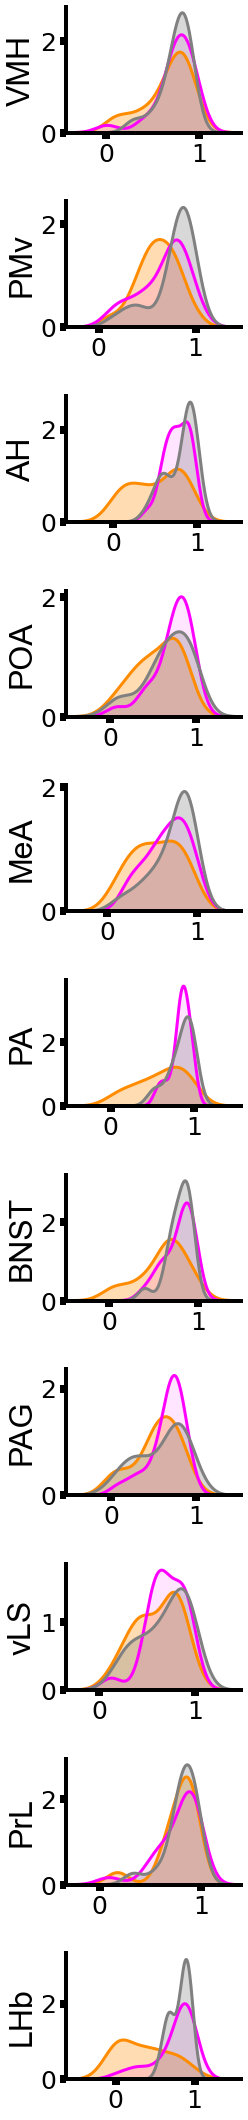

In [112]:
# plot distributions
new_idx = np.array([12, 16, 8, 4, 10, 20, 6, 14, 2, 0, 18])
norm_idx = (new_idx/2).astype(int)
all_labels = [x.replace(' (E)', '').replace(' (I)', '').replace(' (DA)','') for x in np.array(region_ids)[new_idx]]
p_values = []
first_n_attacks = 3 # use 3
fig, ax = plt.subplots(11, 1, figsize=(4, 30))
# ax = ax.flatten()

for r,roi in enumerate(norm_idx):

    ### AGG
    agg_distbs = []
    for mouse in agg_rsquareds_HF.keys():
        agg_distbs.extend(agg_rsquareds_HF[mouse][roi, :][:first_n_attacks])
    agg_distbs = np.array(agg_distbs)
    agg_distbs = agg_distbs[~np.isnan(agg_distbs)]

    ### OBS
    obs_distbs = []
    for mouse in obs_rsquareds_HF.keys():
        obs_distbs.extend(obs_rsquareds_HF[mouse][roi, :][:first_n_attacks])
    obs_distbs = np.array(obs_distbs)
    obs_distbs = obs_distbs[~np.isnan(obs_distbs)]

    ### NON
    non_distbs = []
    for mouse in non_rsquareds_HF.keys():
        non_distbs.extend(non_rsquareds_HF[mouse][roi, :][:first_n_attacks])
    non_distbs = np.array(non_distbs)
    non_distbs = non_distbs[~np.isnan(non_distbs)]
    print(all_labels[r])
    print('AGG = %d, OBS = %d, NON = %d' % (len(agg_distbs), len(obs_distbs), len(non_distbs)))

    # plot everything
    sns.kdeplot(agg_distbs, ax=ax[r], color='darkorange', multiple='layer', fill=True, alpha=0.3, lw=0)
    sns.kdeplot(agg_distbs, ax=ax[r], color='darkorange', lw=3)
    sns.kdeplot(obs_distbs, ax=ax[r], color='magenta', multiple='layer', fill=True, alpha=0.1, lw=0)
    sns.kdeplot(obs_distbs, ax=ax[r], color='magenta', lw=3)
    sns.kdeplot(non_distbs, ax=ax[r], color='grey', multiple='layer', fill=True, alpha=0.3, lw=0)
    sns.kdeplot(non_distbs, ax=ax[r], color='grey', lw=3)
    ax[roi].set_ylabel(all_labels[roi], fontfamily='Arial', fontsize=32)

    # tests
    ks1, p_value1 = ks_2samp(agg_distbs, non_distbs)
    ks2, p_value2 = ks_2samp(obs_distbs, agg_distbs)
    ks3, p_value3 = ks_2samp(obs_distbs, non_distbs)
    pvalues = [p_value1, p_value2, p_value3]
    _, pvals_corrected, _, _ = multipletests(pvalues, method='fdr_tsbh')

    print('AGG vs NON; p = %f' % pvals_corrected[0])
    print('OBS vs AGG; p = %f' % pvals_corrected[1])
    print('OBS vs NON; p = %f' % pvals_corrected[2])

    print('###')

sns.despine()
plt.tight_layout()
# plt.savefig('./figures/agg_obs_non_r2_hardfight.svg', dpi=300)	

3. Map all I2E correlation distributions

In [121]:
period = [0, 400] # this
EI_regions = np.array([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20])

agg_rsquareds_HF = {}
for mouse in HF_agg_dict.keys():
    sample = HF_agg_dict[mouse]
    r_squared_array = np.zeros((len(EI_regions), sample.shape[0]))
    r_squared_array[:] = np.nan
    for r, region in enumerate(EI_regions):
        I_idxs = np.asarray([int(x) for x in EI_regions+1 if int(region+1) != x])
        X = sample[:, :, I_idxs]
        X = X[:, :, ~np.all(np.isnan(X), axis=(0, 1))] # clean rois with no data
        X = X[~np.any(np.isnan(X), axis=(1, 2)), :, :] # clean trials with no data
        y = sample[:, :, region]
        for trial in np.arange(X.shape[0]):
            X_trial = X[trial, :, :][period[0]:period[1]]
            y_trial = y[trial, :]
            y_trial = y_trial[~np.isnan(y_trial)]
            y_trial = y_trial.reshape(-1, 1)[period[0]:period[1]]
            try:
                model = sm.OLS(y_trial, X_trial).fit()
            except ValueError:
                continue
            r_squared_array[r, trial] = model.rsquared
    agg_rsquareds_HF[mouse] = r_squared_array

obs_rsquareds_HF = {}
for mouse in HF_obs_dict.keys():
    sample = HF_obs_dict[mouse]
    r_squared_array = np.zeros((len(EI_regions), sample.shape[0]))
    r_squared_array[:] = np.nan
    for r, region in enumerate(EI_regions):
        I_idxs = np.asarray([int(x) for x in EI_regions+1 if int(region+1) != x])
        X = sample[:, :, I_idxs]
        X = X[:, :, ~np.all(np.isnan(X), axis=(0, 1))] # clean rois with no data
        X = X[~np.any(np.isnan(X), axis=(1, 2)), :, :] # clean trials with no data
        y = sample[:, :, region]
        for trial in np.arange(X.shape[0]):
            X_trial = X[trial, :, :][period[0]:period[1]]
            y_trial = y[trial, :]
            y_trial = y_trial[~np.isnan(y_trial)]
            y_trial = y_trial.reshape(-1, 1)[period[0]:period[1]]
            model = sm.OLS(y_trial, X_trial).fit()
            r_squared_array[r, trial] = model.rsquared
    obs_rsquareds_HF[mouse] = r_squared_array

non_rsquareds_HF = {}
for mouse in HF_non_dict.keys():
    sample = HF_non_dict[mouse]
    r_squared_array = np.zeros((len(EI_regions), sample.shape[0]))
    r_squared_array[:] = np.nan
    for r, region in enumerate(EI_regions):
        I_idxs = np.asarray([int(x) for x in EI_regions+1 if int(region+1) != x])
        X = sample[:, :, I_idxs]
        X = X[:, :, ~np.all(np.isnan(X), axis=(0, 1))] # clean rois with no data
        X = X[~np.any(np.isnan(X), axis=(1, 2)), :, :] # clean trials with no data
        y = sample[:, :, region]
        for trial in np.arange(X.shape[0]):
            X_trial = X[trial, :, :][period[0]:period[1]]
            y_trial = y[trial, :]
            y_trial = y_trial[~np.isnan(y_trial)]
            y_trial = y_trial.reshape(-1, 1)[period[0]:period[1]]
            model = sm.OLS(y_trial, X_trial).fit()
            r_squared_array[r, trial] = model.rsquared
    non_rsquareds_HF[mouse] = r_squared_array



AGG vs NON VMH : 0.292314
OBS vs NON VMH : 0.738195
###
AGG vs NON PMv : 0.138792
OBS vs NON PMv : 0.380325
###
AGG vs NON AH : 0.009358
OBS vs NON AH : 0.240359
###
AGG vs NON POA : 0.105588
OBS vs NON POA : 0.462221
###
AGG vs NON MeA : 0.451971
OBS vs NON MeA : 0.882971
###
AGG vs NON PA : 0.669409
OBS vs NON PA : 0.669409
###
AGG vs NON BNST : 0.983635
OBS vs NON BNST : 0.402319
###
AGG vs NON PAG : 0.301457
OBS vs NON PAG : 0.513423
###
AGG vs NON vLS : 0.273495
OBS vs NON vLS : 0.285216
###
AGG vs NON PrL : 0.312731
OBS vs NON PrL : 0.860853
###
AGG vs NON LHb : 0.000537
OBS vs NON LHb : 0.351364
###


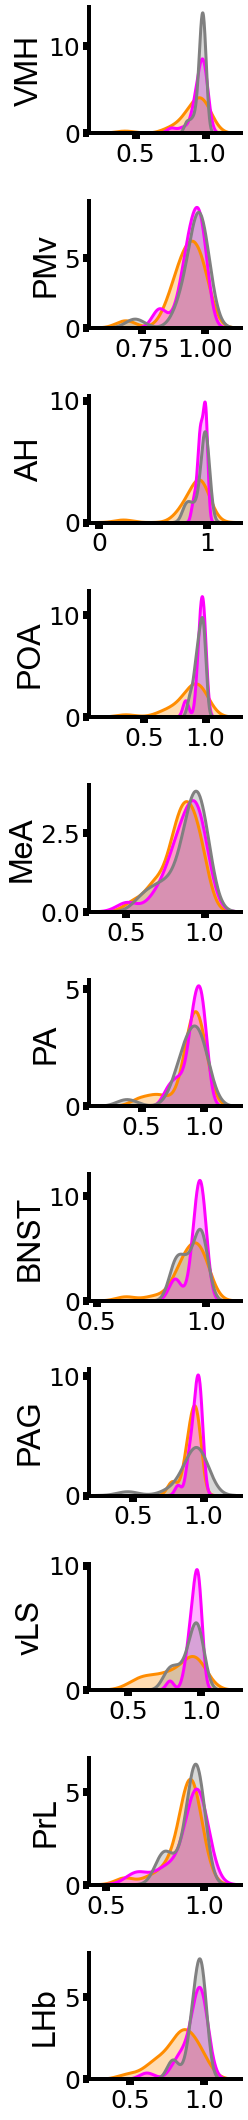

In [122]:
# plot distributions
new_idx = np.array([12, 16, 8, 4, 10, 20, 6, 14, 2, 0, 18])
norm_idx = (new_idx/2).astype(int)
all_labels = [x.replace(' (E)', '').replace(' (I)', '').replace(' (DA)','') for x in np.array(region_ids)[new_idx]]
first_n_attacks = 3 # use 3
fig, ax = plt.subplots(11, 1, figsize=(4, 30))
# ax = ax.flatten()

for r,roi in enumerate(norm_idx):

    ### AGG
    agg_distbs = []
    for mouse in agg_rsquareds_HF.keys():
        agg_distbs.extend(agg_rsquareds_HF[mouse][roi, :][:first_n_attacks])
    agg_distbs = np.array(agg_distbs)
    agg_distbs = agg_distbs[~np.isnan(agg_distbs)]

    ### OBS
    obs_distbs = []
    for mouse in obs_rsquareds_HF.keys():
        obs_distbs.extend(obs_rsquareds_HF[mouse][roi, :][:first_n_attacks])
    obs_distbs = np.array(obs_distbs)
    obs_distbs = obs_distbs[~np.isnan(obs_distbs)]

    ### NON
    non_distbs = []
    for mouse in non_rsquareds_HF.keys():
        non_distbs.extend(non_rsquareds_HF[mouse][roi, :][:first_n_attacks])
    non_distbs = np.array(non_distbs)
    non_distbs = non_distbs[~np.isnan(non_distbs)]

    # plot everything
    sns.kdeplot(agg_distbs, ax=ax[r], color='darkorange', multiple='layer', fill=True, alpha=0.3, lw=0)
    sns.kdeplot(agg_distbs, ax=ax[r], color='darkorange', lw=3)
    sns.kdeplot(obs_distbs, ax=ax[r], color='magenta', multiple='layer', fill=True, alpha=0.3, lw=0)
    sns.kdeplot(obs_distbs, ax=ax[r], color='magenta', lw=3)
    sns.kdeplot(non_distbs, ax=ax[r], color='grey', multiple='layer', fill=True, alpha=0.3, lw=0)
    sns.kdeplot(non_distbs, ax=ax[r], color='grey', lw=3)
    ax[roi].set_ylabel(all_labels[roi], fontfamily='Arial', fontsize=32)

    # tests

    _, p_value1 = ks_2samp(agg_distbs, non_distbs)
    # _, p_value2 = ks_2samp(obs_distbs, agg_distbs)
    _, p_value3 = ks_2samp(obs_distbs, non_distbs)
    pvalues = [p_value1, p_value3]
    _, pvals_corrected, _, _ = multipletests(pvalues, method='fdr_tsbh')
    print('AGG vs NON %s : %f' % (all_labels[r], pvals_corrected[0]))
    # print('OBS vs AGG %s : %f' % (all_labels[r], pvals_corrected[1]))
    print('OBS vs NON %s : %f' % (all_labels[r], pvals_corrected[1]))
    print('###')

sns.despine()
plt.tight_layout()
# plt.savefig('./figures/agg_obs_non_r2_hardfight.svg', dpi=300)	

4. Map E2E correlation distributions

In [315]:
period = [200, 400] # this
# period = [0, 480]
EI_regions = np.array([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20])

agg_rsquareds_HF = {}
for mouse in HF_agg_dict.keys():
    sample = HF_agg_dict[mouse]
    r_squared_array = np.zeros((len(EI_regions), sample.shape[0]))
    r_squared_array[:] = np.nan
    for r, region in enumerate(EI_regions):
        E_idxs = np.asarray([int(x) for x in EI_regions if int(region) != x])
        X = sample[:, :, E_idxs]
        X = X[:, :, ~np.all(np.isnan(X), axis=(0, 1))] # clean rois with no data
        X = X[~np.any(np.isnan(X), axis=(1, 2)), :, :] # clean trials with no data
        y = sample[:, :, region]
        for trial in np.arange(X.shape[0]):
            X_trial = X[trial, :, :][period[0]:period[1]]
            y_trial = y[trial, :]
            y_trial = y_trial[~np.isnan(y_trial)]
            y_trial = y_trial.reshape(-1, 1)[period[0]:period[1]]
            try:
                model = sm.OLS(y_trial, X_trial).fit()
            except ValueError:
                continue
            r_squared_array[r, trial] = model.rsquared
    agg_rsquareds_HF[mouse] = r_squared_array

obs_rsquareds_HF = {}
for mouse in HF_obs_dict.keys():
    sample = HF_obs_dict[mouse]
    r_squared_array = np.zeros((len(EI_regions), sample.shape[0]))
    r_squared_array[:] = np.nan
    for r, region in enumerate(EI_regions):
        E_idxs = np.asarray([int(x) for x in EI_regions if int(region) != x])
        X = sample[:, :, E_idxs]
        X = X[:, :, ~np.all(np.isnan(X), axis=(0, 1))] # clean rois with no data
        X = X[~np.any(np.isnan(X), axis=(1, 2)), :, :] # clean trials with no data
        y = sample[:, :, region]
        for trial in np.arange(X.shape[0]):
            X_trial = X[trial, :, :][period[0]:period[1]]
            y_trial = y[trial, :]
            y_trial = y_trial[~np.isnan(y_trial)]
            y_trial = y_trial.reshape(-1, 1)[period[0]:period[1]]
            model = sm.OLS(y_trial, X_trial).fit()
            r_squared_array[r, trial] = model.rsquared
    obs_rsquareds_HF[mouse] = r_squared_array

non_rsquareds_HF = {}
for mouse in HF_non_dict.keys():
    sample = HF_non_dict[mouse]
    r_squared_array = np.zeros((len(EI_regions), sample.shape[0]))
    r_squared_array[:] = np.nan
    for r, region in enumerate(EI_regions):
        E_idxs = np.asarray([int(x) for x in EI_regions if int(region) != x])
        X = sample[:, :, E_idxs]
        X = X[:, :, ~np.all(np.isnan(X), axis=(0, 1))] # clean rois with no data
        X = X[~np.any(np.isnan(X), axis=(1, 2)), :, :] # clean trials with no data
        y = sample[:, :, region]
        for trial in np.arange(X.shape[0]):
            X_trial = X[trial, :, :][period[0]:period[1]]
            y_trial = y[trial, :]
            y_trial = y_trial[~np.isnan(y_trial)]
            y_trial = y_trial.reshape(-1, 1)[period[0]:period[1]]
            model = sm.OLS(y_trial, X_trial).fit()
            r_squared_array[r, trial] = model.rsquared
    non_rsquareds_HF[mouse] = r_squared_array

AGG vs NON VMH : 0.817202
OBS vs AGG VMH : 0.242921
OBS vs NON VMH : 0.242921
###
AGG vs NON PMv : 0.795051
OBS vs AGG PMv : 0.795051
OBS vs NON PMv : 0.818276
###
AGG vs NON AH : 0.305462
OBS vs AGG AH : 0.305462
OBS vs NON AH : 0.305462
###
AGG vs NON POA : 0.434197
OBS vs AGG POA : 0.075623
OBS vs NON POA : 0.108790
###
AGG vs NON MeA : 0.913575
OBS vs AGG MeA : 0.913575
OBS vs NON MeA : 0.944901
###
AGG vs NON PA : 0.860853
OBS vs AGG PA : 0.860853
OBS vs NON PA : 0.860853
###
AGG vs NON BNST : 0.195622
OBS vs AGG BNST : 0.767841
OBS vs NON BNST : 0.195622
###
AGG vs NON PAG : 0.483161
OBS vs AGG PAG : 0.483161
OBS vs NON PAG : 0.513423
###
AGG vs NON vLS : 0.133845
OBS vs AGG vLS : 0.133845
OBS vs NON vLS : 0.772491
###
AGG vs NON PrL : 0.865952
OBS vs AGG PrL : 0.713056
OBS vs NON PrL : 0.846900
###
AGG vs NON LHb : 0.000187
OBS vs AGG LHb : 0.000673
OBS vs NON LHb : 0.302067
###


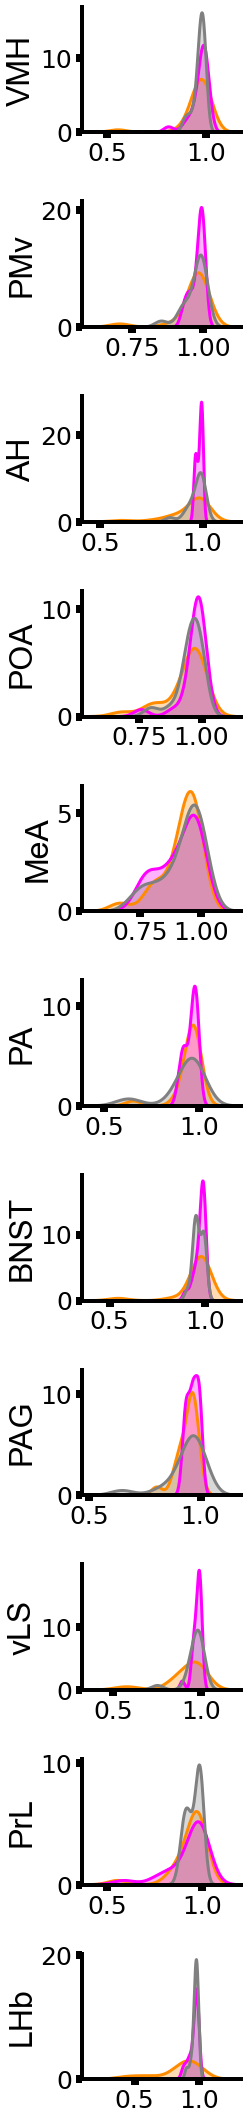

In [316]:
# plot distributions
new_idx = np.array([12, 16, 8, 4, 10, 20, 6, 14, 2, 0, 18])
norm_idx = (new_idx/2).astype(int)
all_labels = [x.replace(' (E)', '').replace(' (I)', '').replace(' (DA)','') for x in np.array(region_ids)[new_idx]]
first_n_attacks = 3 # use 3
fig, ax = plt.subplots(11, 1, figsize=(4, 30))
# ax = ax.flatten()

for r,roi in enumerate(norm_idx):

    ### AGG
    agg_distbs = []
    for mouse in agg_rsquareds_HF.keys():
        agg_distbs.extend(agg_rsquareds_HF[mouse][roi, :][:first_n_attacks])
    agg_distbs = np.array(agg_distbs)
    agg_distbs = agg_distbs[~np.isnan(agg_distbs)]

    ### OBS
    obs_distbs = []
    for mouse in obs_rsquareds_HF.keys():
        obs_distbs.extend(obs_rsquareds_HF[mouse][roi, :][:first_n_attacks])
    obs_distbs = np.array(obs_distbs)
    obs_distbs = obs_distbs[~np.isnan(obs_distbs)]

    ### NON
    non_distbs = []
    for mouse in non_rsquareds_HF.keys():
        non_distbs.extend(non_rsquareds_HF[mouse][roi, :][:first_n_attacks])
    non_distbs = np.array(non_distbs)
    non_distbs = non_distbs[~np.isnan(non_distbs)]

    # plot everything
    sns.kdeplot(agg_distbs, ax=ax[r], color='darkorange', multiple='layer', fill=True, alpha=0.3, lw=0)
    sns.kdeplot(agg_distbs, ax=ax[r], color='darkorange', lw=3)
    sns.kdeplot(obs_distbs, ax=ax[r], color='magenta', multiple='layer', fill=True, alpha=0.3, lw=0)
    sns.kdeplot(obs_distbs, ax=ax[r], color='magenta', lw=3)
    sns.kdeplot(non_distbs, ax=ax[r], color='grey', multiple='layer', fill=True, alpha=0.3, lw=0)
    sns.kdeplot(non_distbs, ax=ax[r], color='grey', lw=3)


    ax[roi].set_ylabel(all_labels[roi], fontfamily='Arial', fontsize=32)

    # tests

    _, p_value1 = ks_2samp(agg_distbs, non_distbs)
    _, p_value2 = ks_2samp(obs_distbs, agg_distbs)
    _, p_value3 = ks_2samp(obs_distbs, non_distbs)
    pvalues = [p_value1, p_value2, p_value3]
    _, pvals_corrected, _, _ = multipletests(pvalues, method='fdr_tsbh')
    print('AGG vs NON %s : %f' % (all_labels[r], pvals_corrected[0]))
    print('OBS vs AGG %s : %f' % (all_labels[r], pvals_corrected[1]))
    print('OBS vs NON %s : %f' % (all_labels[r], pvals_corrected[2]))
    print('###')

sns.despine()
plt.tight_layout()
# plt.savefig('./figures/agg_obs_non_r2_hardfight.svg', dpi=300)	

5. Map region-to-region connections

In [96]:
# run GLM on each trial for each region / individual
from statsmodels.tools.sm_exceptions import PerfectSeparationError
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from tqdm import tqdm

constrained_idxs = np.array([16, 8, 4, 14, 10, 20, 13, 17, 9, 5, 11, 21]) # pmv, ah, poa, pag, mea, vmh, pmv, ah, poa, mea
n_perms = 50
roi2pred = 12
period = [260, 540] # -1 to +6

In [97]:
np.random.seed(876867)
mean_func = np.median

### RUN AGG

HF_agg_rsquareds = {}
HF_agg_weights = {}
HF_agg_kos = {}

pbar = tqdm(enumerate(HF_agg_dict.keys()), total=len(HF_agg_dict.keys())) # progress bar
for a, mouse in pbar:
    sample = HF_agg_dict[mouse]
    r_squared_array = np.zeros((sample.shape[0]))
    r_squared_array[:] = np.nan
    weights_array = np.zeros((len(constrained_idxs), sample.shape[0]))
    weights_array[:] = np.nan
    kos_array = np.zeros((len(constrained_idxs), sample.shape[0]))
    kos_array[:] = np.nan

    # format X and y
    y = sample[:, :, roi2pred]
    y = y[:, :, ~np.all(np.isnan(y), axis=(0, 1))]

    # format X
    X = sample[:, :, constrained_idxs]
    X = X[:, :, ~np.all(np.isnan(X), axis=(0, 1))] # clean rois with no data
    X = X[~np.any(np.isnan(X), axis=(1, 2)), :, :] # clean trials with no data
    if X.shape[-1] < len(constrained_idxs):
        print('Skipping AGG %s' % mouse)
        continue

    # run glm for each trial
    for trial in np.arange(X.shape[0]):

        # fit model
        X_trial = X[trial][period[0]:period[1]]
        y_trial = y[trial][period[0]:period[1]]
        try:
            model = sm.GLM(y_trial, X_trial).fit()
        except ValueError:
            continue
        best_score = r2_score(y_trial, model.predict(X_trial))
        if best_score<0:
            best_score=0

        # perform region knockouts
        knockouts = np.zeros((X.shape[-1]))
        for knockout_idx in np.arange(X.shape[-1]):
            avg_ko = []
            for n in np.arange(n_perms):
                X_shuffled = X_trial.copy()
                np.random.shuffle(X_shuffled[:, knockout_idx])
                y_pred = model.predict(X_shuffled)
                ko_score = r2_score(y_trial, y_pred)
                if ko_score < 0:
                    ko_score = 0
                avg_ko.append(ko_score)
            ko_score = mean_func(avg_ko) 
            knockout_score_difference = best_score - ko_score
            if knockout_score_difference < 0:
                knockout_score_difference = 0
            knockouts[knockout_idx] = knockout_score_difference

        # store results 
        r_squared_array[trial] = best_score
        weights_array[:, trial] = model.params.flatten()
        kos_array[:, trial] = knockouts

    HF_agg_rsquareds[mouse] = r_squared_array
    HF_agg_weights[mouse] = weights_array
    HF_agg_kos[mouse] = kos_array

# ### RUN OBS

HF_obs_rsquareds = {}
HF_obs_weights = {}
HF_obs_kos = {}

pbar = tqdm(enumerate(HF_obs_dict.keys()), total=len(HF_obs_dict.keys())) # progress bar
for a, mouse in pbar:
    sample = HF_obs_dict[mouse]
    r_squared_array = np.zeros((sample.shape[0]))
    r_squared_array[:] = np.nan
    weights_array = np.zeros((len(constrained_idxs), sample.shape[0]))
    weights_array[:] = np.nan
    kos_array = np.zeros((len(constrained_idxs), sample.shape[0]))
    kos_array[:] = np.nan

    # format X and y
    y = sample[:, :, roi2pred]
    y = y[:, :, ~np.all(np.isnan(y), axis=(0, 1))]

    # format X
    X = sample[:, :, constrained_idxs]
    X = X[:, :, ~np.all(np.isnan(X), axis=(0, 1))] # clean rois with no data
    X = X[~np.any(np.isnan(X), axis=(1, 2)), :, :] # clean trials with no data
    if X.shape[-1] < len(constrained_idxs):
        print('Skipping OBS %s' % mouse)
        continue

    # run glm for each trial
    for trial in np.arange(X.shape[0]):

        # fit model
        X_trial = X[trial][period[0]:period[1]]
        y_trial = y[trial][period[0]:period[1]]
        try:
            model = sm.GLM(y_trial, X_trial).fit()
        except ValueError:
            continue
        best_score = r2_score(y_trial, model.predict(X_trial))
        if best_score<0:
            best_score=0

        # perform region knockouts
        knockouts = np.zeros((X.shape[-1]))
        for knockout_idx in np.arange(X.shape[-1]):
            avg_ko = []
            for n in np.arange(n_perms):
                X_shuffled = X_trial.copy()
                np.random.shuffle(X_shuffled[:, knockout_idx])
                y_pred = model.predict(X_shuffled)
                ko_score = r2_score(y_trial, y_pred)
                if ko_score < 0:
                    ko_score = 0
                avg_ko.append(ko_score)
            ko_score = mean_func(avg_ko) 
            knockout_score_difference = best_score - ko_score
            if knockout_score_difference < 0:
                knockout_score_difference = 0
            knockouts[knockout_idx] = knockout_score_difference

        # store results 
        r_squared_array[trial] = best_score
        weights_array[:, trial] = model.params.flatten()
        kos_array[:, trial] = knockouts
    
    HF_obs_rsquareds[mouse] = r_squared_array
    HF_obs_weights[mouse] = weights_array
    HF_obs_kos[mouse] = kos_array

### RUN NON

HF_non_rsquareds = {}
HF_non_weights = {}
HF_non_kos = {}

pbar = tqdm(enumerate(HF_non_dict.keys()), total=len(HF_non_dict.keys())) # progress bar
for a, mouse in pbar:
    sample = HF_non_dict[mouse]
    r_squared_array = np.zeros((sample.shape[0]))
    r_squared_array[:] = np.nan
    weights_array = np.zeros((len(constrained_idxs), sample.shape[0]))
    weights_array[:] = np.nan
    kos_array = np.zeros((len(constrained_idxs), sample.shape[0]))
    kos_array[:] = np.nan

    # format X and y
    y = sample[:, :, roi2pred]
    y = y[:, :, ~np.all(np.isnan(y), axis=(0, 1))]

    # format X
    X = sample[:, :, constrained_idxs]
    X = X[:, :, ~np.all(np.isnan(X), axis=(0, 1))] # clean rois with no data
    X = X[~np.any(np.isnan(X), axis=(1, 2)), :, :] # clean trials with no data
    if X.shape[-1] < len(constrained_idxs):
        print('Skipping NON %s' % mouse)
        continue

    # run glm for each trial
    for trial in np.arange(X.shape[0]):

        # fit model
        X_trial = X[trial][period[0]:period[1]]
        y_trial = y[trial][period[0]:period[1]]
        try:
            try:
                model = sm.GLM(y_trial, X_trial).fit()
            except ValueError:
                continue
        except PerfectSeparationError:
            print('Perfect Separation Error in NON %s, trial %s' % (mouse, trial))
            print('Skipping trial...')
            continue


        best_score = r2_score(y_trial, model.predict(X_trial))
        if best_score<0:
            best_score=0

        # perform region knockouts
        knockouts = np.zeros((X.shape[-1]))
        for knockout_idx in np.arange(X.shape[-1]):
            avg_ko = []
            for n in np.arange(n_perms): # 3
                X_shuffled = X_trial.copy()
                np.random.shuffle(X_shuffled[:, knockout_idx])
                y_pred = model.predict(X_shuffled)
                ko_score = r2_score(y_trial, y_pred)
                if ko_score < 0:
                    ko_score = 0
                avg_ko.append(ko_score)
            ko_score = mean_func(avg_ko) 
            knockout_score_difference = best_score - ko_score
            if knockout_score_difference < 0:
                knockout_score_difference = 0
            knockouts[knockout_idx] = knockout_score_difference

        # store results 
        r_squared_array[trial] = best_score
        weights_array[:, trial] = model.params.flatten()
        kos_array[:, trial] = knockouts

    HF_non_rsquareds[mouse] = r_squared_array
    HF_non_weights[mouse] = weights_array
    HF_non_kos[mouse] = kos_array

100%|██████████| 9/9 [00:04<00:00,  1.84it/s]


Skipping AGG mouse7
Skipping AGG mouse8


100%|██████████| 6/6 [00:03<00:00,  1.65it/s]


PMv
AGG = 61, OBS = 84, NON = 46
###
AH
AGG = 61, OBS = 84, NON = 46
###
POA
AGG = 61, OBS = 84, NON = 46
###
PAG
AGG = 61, OBS = 84, NON = 46
###
MeA
AGG = 61, OBS = 84, NON = 46
###
PA
AGG = 61, OBS = 84, NON = 46
###
VMH
AGG = 61, OBS = 84, NON = 46
###
PMv
AGG = 61, OBS = 84, NON = 46
###
AH
AGG = 61, OBS = 84, NON = 46
###
POA
AGG = 61, OBS = 84, NON = 46
###
MeA
AGG = 61, OBS = 84, NON = 46
###
PA
AGG = 61, OBS = 84, NON = 46
###


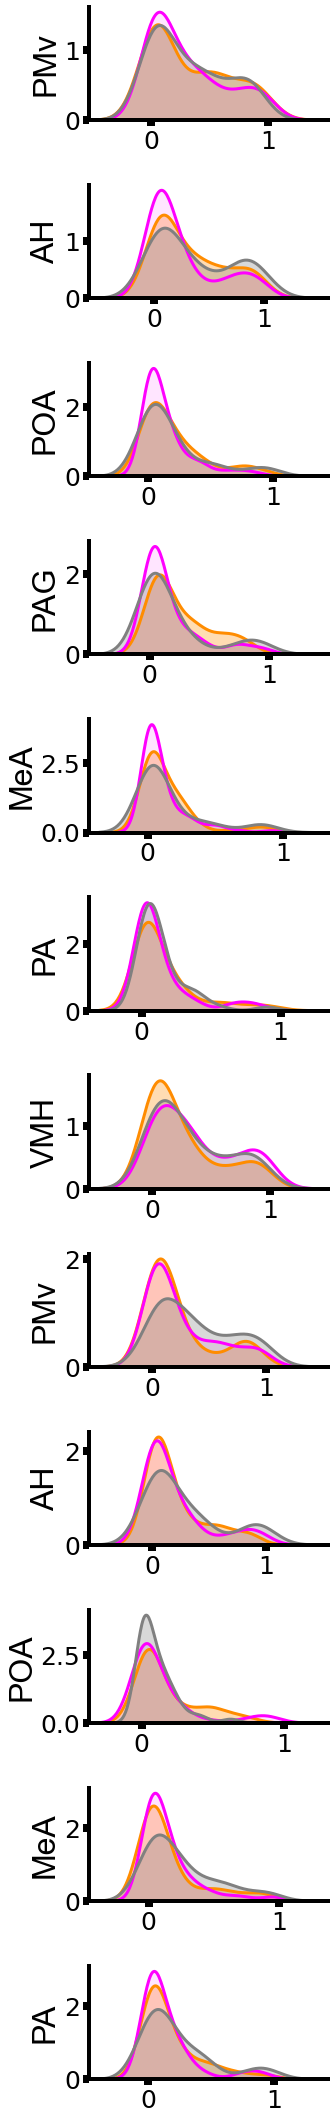

In [105]:
# plot distributions
new_idx = np.arange(len(constrained_idxs))
norm_idx = new_idx.copy()
all_labels = [x.replace(' (E)', '').replace(' (I)', '').replace(' (DA)','') for x in np.array(region_ids)[constrained_idxs]]
first_n_attacks = None
fig, ax = plt.subplots(len(constrained_idxs), 1, figsize=(5.2, len(constrained_idxs)*2.5))
rows = []
# ax = ax.flatten()

for r,roi in enumerate(norm_idx):

    ### AGG
    agg_distbs = []
    for mouse in HF_agg_kos.keys():
        agg_distbs.extend(HF_agg_kos[mouse][roi, :][:first_n_attacks])
    agg_distbs = np.array(agg_distbs)
    agg_distbs = agg_distbs[~np.isnan(agg_distbs)]

    ### OBS
    obs_distbs = []
    for mouse in HF_obs_kos.keys():
        obs_distbs.extend(HF_obs_kos[mouse][roi, :][:first_n_attacks])
    obs_distbs = np.array(obs_distbs)
    obs_distbs = obs_distbs[~np.isnan(obs_distbs)]

    ### NON
    non_distbs = []
    for mouse in HF_non_kos.keys():
        non_distbs.extend(HF_non_kos[mouse][roi, :][:first_n_attacks])
    non_distbs = np.array(non_distbs)
    non_distbs = non_distbs[~np.isnan(non_distbs)]

    print(all_labels[r])
    print('AGG = %d, OBS = %d, NON = %d' % (len(agg_distbs), len(obs_distbs), len(non_distbs)))

    # plot everything
    sns.kdeplot(agg_distbs, ax=ax[r], color='darkorange', multiple='layer', fill=True, alpha=0.3, lw=0)
    sns.kdeplot(agg_distbs, ax=ax[r], color='darkorange', lw=3)
    sns.kdeplot(obs_distbs, ax=ax[r], color='magenta', multiple='layer', fill=True, alpha=0.1, lw=0)
    sns.kdeplot(obs_distbs, ax=ax[r], color='magenta', lw=3)
    sns.kdeplot(non_distbs, ax=ax[r], color='grey', multiple='layer', fill=True, alpha=0.3, lw=0)
    sns.kdeplot(non_distbs, ax=ax[r], color='grey', lw=3)
    ax[roi].set_ylabel(all_labels[roi], fontfamily='Arial', fontsize=32)

    # tests

    ks1, p_value1 = ks_2samp(agg_distbs, non_distbs)
    ks2, p_value2 = ks_2samp(obs_distbs, non_distbs)
    pvalues = [p_value1, p_value2]
    _, pvals_corrected, _, _ = multipletests(pvalues, method='fdr_tsbh')
    # print('AGG vs NON %s : corrected %f' % (all_labels[r], pvals_corrected[0]))
    # print('OBS vs NON %s : corrected %f' % (all_labels[r], pvals_corrected[1]))
    print('AGG vs NON KS = %f, p = %f; OBS vs NON KS = %f, p = %f' % (ks1, p_value1, ks2, p_value2))
    # rows.append('AGG p = %f, OBS p = %f' % (pvals_corrected[0], pvals_corrected[1]))
    print('###')

sns.despine()
plt.tight_layout()
# plt.savefig('./figures/agg_obs_non_kos_hardfight.svg', dpi=300)	

df = pd.DataFrame(rows)
# df.to_excel('stats_list.xlsx')